In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


In [4]:
train = pd.read_csv("/kaggle/input/home-credit-manual-engineered-features/m_train_small.csv").astype("float32")

In [5]:
train.AMT_CREDIT.mean()

599025.94

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 344 entries, EXT_SOURCE_1 to SK_ID_CURR
dtypes: float32(344)
memory usage: 403.5 MB


In [7]:
from sklearn.impute import SimpleImputer
target = train["TARGET"]
X_train = train.drop(columns = ["TARGET"])
imputer = SimpleImputer()
X_train = imputer.fit_transform(X_train)


In [8]:
from keras import backend as K
import tensorflow as tf
import keras
from keras import layers
from keras import models


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


from imblearn.over_sampling import SMOTE

std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
pca = PCA(n_components = 250)
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, target)


X_train = pca.fit_transform(X_train)

#print(pca.explained_variance_ratio_.cumsum())





#pca = PCA(n_components = 50)

#X_train = pca.fit_transform(X_train)
#X_train = umap.UMAP(n_components=122).fit_transform(X_train)
X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=0.012) # Argued by https://www.ncbi.nlm.nih.gov/pubmed/18255701 as optimal value in this case
#X_train, y_train = sm.fit_resample(X_train, y_train)


"""
print("### AutoFeat with %i feateng_steps" % 1)
afreg = AutoFeatClassifier(verbose=1, feateng_steps=1, max_gb = 0.50, 
                           transformations = ("exp", "^2", '^3', "abs"))
df = afreg.fit_transform(X_train, y_train)
r2 = afreg.score(X_test, y_test)
print("## Final R^2: %.4f" % r2)
plt.figure()
plt.scatter(afreg.predict(X_test), y_test, s=2);
plt.title("%i FE steps (R^2: %.4f; %i new features)" % (1, r2, len(afreg.new_feat_cols_)))
"""

'\nprint("### AutoFeat with %i feateng_steps" % 1)\nafreg = AutoFeatClassifier(verbose=1, feateng_steps=1, max_gb = 0.50, \n                           transformations = ("exp", "^2", \'^3\', "abs"))\ndf = afreg.fit_transform(X_train, y_train)\nr2 = afreg.score(X_test, y_test)\nprint("## Final R^2: %.4f" % r2)\nplt.figure()\nplt.scatter(afreg.predict(X_test), y_test, s=2);\nplt.title("%i FE steps (R^2: %.4f; %i new features)" % (1, r2, len(afreg.new_feat_cols_)))\n'

In [9]:
counts = np.bincount(y_train)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(y_train)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

Number of positive samples in training data: 279272 (50.00% of total)


In [10]:
from tensorflow.keras import regularizers

In [11]:
model = keras.Sequential(
    [
        keras.layers.Dense(16, activation="relu", input_shape=(X_train.shape[-1],)),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(4, activation="relu"),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 16)                4016      
_________________________________________________________________
dropout_38 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_78 (Dense)             (None, 16)                80        
_________________________________________________________________
dropout_39 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 17        
Total params: 4,181
Trainable params: 4,181
Non-trainable params: 0
___________________________________________________

In [12]:
pd.DataFrame(X_train).isna().sum().value_counts()

0    250
dtype: int64

In [13]:
def f1_weighted(true, pred): #shapes (batch, 4)

    #for metrics include these two lines, for loss, don't include them
    #these are meant to round 'pred' to exactly zeros and ones
    #predLabels = K.argmax(pred, axis=-1)
    #pred = K.one_hot(predLabels, 4) 


    ground_positives = K.sum(true, axis=0) + K.epsilon()       # = TP + FN
    pred_positives = K.sum(pred, axis=0) + K.epsilon()         # = TP + FP
    true_positives = K.sum(true * pred, axis=0) + K.epsilon()  # = TP
        #all with shape (4,)
    
    precision = true_positives / pred_positives 
    recall = true_positives / ground_positives
        #both = 1 if ground_positives == 0 or pred_positives == 0
        #shape (4,)

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        #still with shape (4,)

    weighted_f1 = f1 * ground_positives / K.sum(ground_positives) 
    weighted_f1 = K.sum(weighted_f1)

    
    return 1 - weighted_f1 #for metrics, return only 'weighted_f1'

In [14]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)*5
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)*5
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [15]:
metrics = [tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.AUC(name = "auc"),
    f1
]

model.compile(
    optimizer=tf.keras.optimizers.Adamax(), loss=f1_loss, metrics=[metrics]
)


#class_weight = {0: weight_for_0, 1: weight_for_1}

history = model.fit(
    X_train,
    y_train,
    batch_size=X_train.shape[0],
    epochs=200,
    validation_data=(X_test, y_test),
    #class_weight = class_weight
)

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 0.7404 - fn: 4536.0000 - fp: 274638.0000 - tn: 4677.0000 - tp: 274736.0000 - precision: 0.5001 - recall: 0.9838 - auc: 0.4241 - f1: 0.2851 - val_loss: 0.7381 - val_fn: 0.0000e+00 - val_fp: 3371.0000 - val_tn: 0.0000e+00 - val_tp: 3414.0000 - val_precision: 0.5032 - val_recall: 1.0000 - val_auc: 0.4171 - val_f1: 0.2883
Epoch 2/200
1/1 [==============================] - 0s 285ms/step - loss: 0.7392 - fn: 12.0000 - fp: 279305.0000 - tn: 10.0000 - tp: 279260.0000 - precision: 0.5000 - recall: 1.0000 - auc: 0.4312 - f1: 0.2857 - val_loss: 0.7369 - val_fn: 0.0000e+00 - val_fp: 3371.0000 - val_tn: 0.0000e+00 - val_tp: 3414.0000 - val_precision: 0.5032 - val_recall: 1.0000 - val_auc: 0.4248 - val_f1: 0.2883
Epoch 3/200
1/1 [==============================] - 0s 355ms/step - loss: 0.7381 - fn: 18.0000 - fp: 279305.0000 - tn: 10.0000 - tp: 279254.0000 - precision: 0.5000 - recall: 0.9999 - auc: 0.4383 - f1: 0.2857 - val_loss: 0

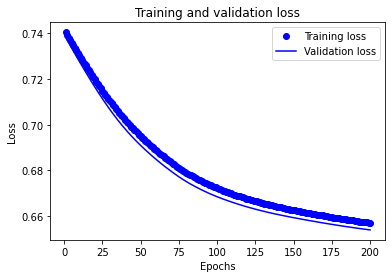

In [16]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

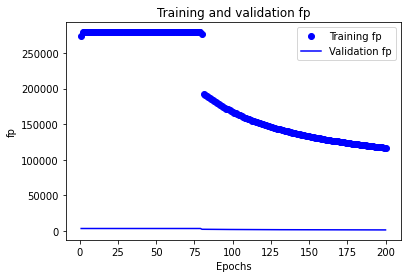

In [17]:
plt.clf()
acc = history_dict["fp"]
val_acc = history_dict["val_fp"]
plt.plot(epochs, acc, "bo", label="Training fp")
plt.plot(epochs, val_acc, "b", label="Validation fp")
plt.title("Training and validation fp")
plt.xlabel("Epochs")
plt.ylabel("fp")
plt.legend()
plt.show()

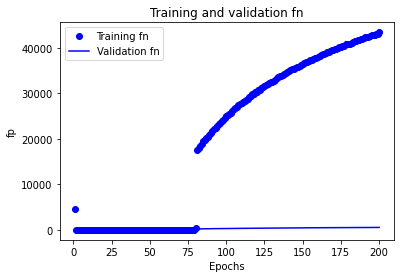

In [18]:
plt.clf()
acc = history_dict["fn"]
val_acc = history_dict["val_fn"]
plt.plot(epochs, acc, "bo", label="Training fn")
plt.plot(epochs, val_acc, "b", label="Validation fn")
plt.title("Training and validation fn")
plt.xlabel("Epochs")
plt.ylabel("fp")
plt.legend()
plt.show()

In [19]:
test = pd.read_csv("/kaggle/input/home-credit-manual-engineered-features/m_test_small.csv")

In [20]:
#test = test.align(train, axis = 1)

In [21]:
test

EXT_SOURCE_1  EXT_SOURCE_2  client_installments_AMT_PAYMENT_min_sum  \
0          0.752614      0.789654                                27746.775   
1          0.564990      0.291656                                43318.800   
2               NaN      0.699787                                66875.265   
3          0.525734      0.509677                               172044.315   
4          0.202145      0.425687                               133169.400   
...             ...           ...                                      ...   
48739           NaN      0.648575                                42667.290   
48740           NaN      0.684596                               289188.225   
48741      0.733503      0.632770                               119849.130   
48742      0.373090      0.445701                               500781.645   
48743           NaN      0.456541                               544264.245   

       EXT_SOURCE_3  DAYS_BIRTH  AMT_CREDIT  AMT_ANNUITY  DAYS_EMPLOYED  \
0          0.159520      -19241    568800.0      20560.5          -2329   
1          0.432962      -18064    222768.0      17370.0          -4469   
2          0.610991      -20038    663264.0      69777.0          -4458   
3          0.612704      -13976   1575000.0      49018.5          -1866   
4               NaN      -13040    625500.0      32067.0          -2191   
...             ...         ...         ...          ...            ...   
48739      0.643026      -19970    412560.0      17473.5          -5169   
48740           NaN      -11186    622413.0      31909.5          -1149   
48741      0.283712      -15922    315000.0      33205.5          -3037   
48742      0.595456      -13968    450000.0      25128.0          -2731   
48743      0.272134      -13962    312768.0      24709.5           -633   

       bureau_DAYS_CREDIT_max  OWN_CAR_AGE  ...  \
0                       -49.0          NaN  ...   
1                       -62.0          NaN  ...   
2                     -1210.0          5.0  ...   
3                      -269.0          NaN  ...   
4                         NaN         16.0  ...   
...                       ...          ...  ...   
48739                  -113.0          NaN  ...   
48740                     NaN          NaN  ...   
48741                  -218.0          4.0  ...   
48742                  -515.0          NaN  ...   
48743                  -760.0         22.0  ...   

       previous_loans_NAME_TYPE_SUITE_Children_count_norm  \
0                                                    0.0    
1                                                    0.0    
2                                                    0.0    
3                                                    0.0    
4                                                    0.0    
...                                                  ...    
48739                                                0.0    
48740                                                0.0    
48741                                                0.0    
48742                                                0.0    
48743                                                0.0    

       previous_loans_DAYS_FIRST_DRAWING_min  \
0                                   365243.0   
1                                   365243.0   
2                                   365243.0   
3                                    -1323.0   
4                                   365243.0   
...                                      ...   
48739                               365243.0   
48740                               365243.0   
48741                               365243.0   
48742                               365243.0   
48743                                 -373.0   

       previous_loans_CHANNEL_TYPE_Regional / Local_count_norm  \
0                                                   0.00         
1                                                   0.00         
2                                               

In [22]:

test = imputer.transform(test)

In [23]:
#pca = PCA(n_components = 50)


test = std_scaler.transform(test)
test = pca.transform(test)

In [24]:
test_model = model.predict(test)
submit = pd.read_csv("/kaggle/input/test-imputed-credit-score/test_imputed.csv")[['SK_ID_CURR']]
submit['TARGET'] = test_model

In [25]:
submit.head()

SK_ID_CURR    TARGET
0      100001  0.470745
1      100005  0.999784
2      100013  0.470745
3      100028  0.470745
4      100038  0.999908

In [26]:
submit.to_csv("test_model_NN.csv", index = False)

In [4]:
import umap

In [3]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [4]:
def f(X):
    return model.predict([X[:,i] for i in range(X.shape[1])]).flatten()

In [7]:
shap.initjs()
def main_thing(coefficient_de_poids):    
    train = pd.read_csv(
        "/kaggle/input/home-credit-manual-engineered-features/m_train_small.csv"
    ).astype("float32")
    from sklearn.impute import SimpleImputer
    target = train["TARGET"]
    X_train = train.drop(columns = ["TARGET"])
    imputer = SimpleImputer()
    X_train = imputer.fit_transform(X_train)
    from keras import backend as K
    import tensorflow as tf
    import keras
    from keras import layers
    from keras import models


    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    from sklearn.decomposition import PCA


    from imblearn.over_sampling import SMOTE

    std_scaler = StandardScaler()
    X_train = std_scaler.fit_transform(X_train)
    #pca = PCA(n_components = 250)
    sm = SMOTE()
    X_train, y_train = sm.fit_resample(X_train, target)


    #X_train = pca.fit_transform(X_train)

    #print(pca.explained_variance_ratio_.cumsum())





    #pca = PCA(n_components = 50)

    #X_train = pca.fit_transform(X_train)
    #X_train = umap.UMAP(n_components=250).fit_transform(X_train)
    X_train, X_test, y_train, y_test = train_test_split(
        X_train,
        y_train,
        test_size=0.012) # Argued by https://www.ncbi.nlm.nih.gov/pubmed/18255701 as optimal value in this case
    #X_train, y_train = sm.fit_resample(X_train, y_train)
    counts = np.bincount(y_train)
    print(
        "Number of positive samples in training data: {} ({:.2f}% of total)".format(
            counts[1], 100 * float(counts[1]) / len(y_train)
        )
    )

    weight_for_0 = 1.0 / counts[0]
    weight_for_1 = 1.0 / counts[1]
    from tensorflow.keras import regularizers
    for indice in range(1, coefficient_de_poids):
        model = keras.Sequential(
            [
                keras.layers.Dense(16, activation="relu", input_shape=(X_train.shape[-1],)),
                keras.layers.Dropout(0.1),
                keras.layers.Dense(8, activation="relu"),
                keras.layers.Dropout(0.1),
                keras.layers.Dense(4, activation="relu"),
                keras.layers.Dense(8, activation="relu"),
                keras.layers.Dropout(0.1),
                keras.layers.Dense(16, activation="relu"),
                keras.layers.Dropout(0.1),
                keras.layers.Dense(1, activation="sigmoid"),
            ]
        )
        model.summary()
        def f1(y_true, y_pred):
            y_pred = K.round(y_pred)
            tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
            tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
            fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)*indice
            fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

            p = tp / (tp + fp + K.epsilon())
            r = tp / (tp + fn + K.epsilon())

            f1 = 2*p*r / (p+r+K.epsilon())
            f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
            return K.mean(f1)
        def FALSE(y_true, y_pred):
            y_pred = K.round(y_pred)
            fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
            fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
            return (fp+fn)*599025

        def f1_loss(y_true, y_pred):

            tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
            tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
            fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)*indice
            fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

            p = tp / (tp + fp + K.epsilon())
            r = tp / (tp + fn + K.epsilon())

            f1 = 2*p*r / (p+r+K.epsilon())
            f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
            return 1 - K.mean(f1)

        metrics = [tf.keras.metrics.FalseNegatives(name="fn"),
            tf.keras.metrics.FalsePositives(name="fp"),
            tf.keras.metrics.TrueNegatives(name="tn"),
            tf.keras.metrics.TruePositives(name="tp"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name = "auc"),
            f1,
            FALSE
        ]

        model.compile(
            optimizer=tf.keras.optimizers.Adamax(), loss=f1_loss, metrics=[metrics]
        )


        #class_weight = {0: weight_for_0, 1: weight_for_1}

        history = model.fit(
            X_train,
            y_train,
            batch_size=X_train.shape[0],
            epochs=150,
            validation_data=(X_test, y_test),
            verbose = 0
            #class_weight = class_weight
        )
        def f(X):
            return model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
        import matplotlib.pyplot as plt
        history_dict = history.history
        loss_values = history_dict["loss"]
        val_loss_values = history_dict["val_loss"]
        epochs = range(1, len(loss_values) + 1)
        plt.plot(epochs, loss_values, "bo", label="Training loss")
        plt.plot(epochs, val_loss_values, "b", label="Validation loss")
        plt.title("Training and validation loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        plt.clf()
        acc = history_dict["fp"]
        val_acc_fp = history_dict["val_fp"]
        plt.plot(epochs, acc, "bo", label="Training fp")
        plt.plot(epochs, val_acc_fp, "b", label="Validation fp")
        plt.title("Training and validation fp")
        plt.xlabel("Epochs")
        plt.ylabel("fp")
        plt.legend()
        plt.show()
        plt.clf()
        acc = history_dict["fn"]
        val_acc_fn = history_dict["val_fn"]
        plt.plot(epochs, acc, "bo", label="Training fn")
        plt.plot(epochs, val_acc_fn, "b", label="Validation fn")
        plt.title("Training and validation fn")
        plt.xlabel("Epochs")
        plt.ylabel("fp")
        plt.legend()
        plt.show()
        acc = history_dict["FALSE"]
        val_acc_false = history_dict["val_FALSE"]
        plt.plot(epochs, acc, "bo", label="Training FALSE")
        plt.plot(epochs, val_acc_fn, "b", label="Validation FALSE")
        plt.title("Training and validation FALSE")
        plt.xlabel("Epochs")
        plt.ylabel("cost")
        plt.legend()
        plt.show()
        acc = history_dict["auc"]
        val_acc = history_dict["val_auc"]
        plt.plot(epochs, acc, "bo", label="Training auc")
        plt.plot(epochs, val_acc, "b", label="Validation auc")
        plt.title("Training and validation auc")
        plt.xlabel("Epochs")
        plt.ylabel("auc")
        plt.legend()
        plt.show()
        print("-----")
        print("step =", indice)
        print("cost of false postive", val_acc_fp[-1]*599025.94) # amount moyen de crédit 599025
        print("cost of false negative", val_acc_fn[-1]*599025.94)
        print("number of false negative", val_acc_fn[-1])
        print("-----")
        print("-----")
        print("cost total = " , val_acc_fp[-1]*599025.94 + val_acc_fn[-1]*599025.94)
        print("-----")
        print("percentage of cost that is false positive", (val_acc_fp[-1]*599025.94*100)/(val_acc_fp[-1]*599025.94 + val_acc_fn[-1]*599025.94))
        print("-----")
        print("percentage of cost that is false negative", (val_acc_fn[-1]*599025.94*100)/(val_acc_fp[-1]*599025.94 + val_acc_fn[-1]*599025.94))
        test = pd.read_csv("/kaggle/input/home-credit-manual-engineered-features/m_test_small.csv")
        test = imputer.transform(test)
        
        test = std_scaler.transform(test)
        #test = pca.transform(test)

        test_model = model.predict(test)
        submit = pd.read_csv("/kaggle/input/test-imputed-credit-score/test_imputed.csv")[['SK_ID_CURR']]
        submit['TARGET'] = test_model
        X_train_features = pd.DataFrame(X_train, columns = train.drop(columns = ["TARGET"]).columns) 
        submit.to_csv("test_model_NN{}.csv".format(indice), index = False)
        explainer = shap.DeepExplainer(model, X_test)
        shap_values = explainer.shap_values( X_test[:50,:])
        #shap.force_plot(explainer.expected_value, shap_values[-1],  X_train_features.iloc[280:330,:])
        shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = X_train_features.columns)

Number of positive samples in training data: 279337 (50.01% of total)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_11 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_23 (Dense)             (None, 8)                 40        
__________________________________________________

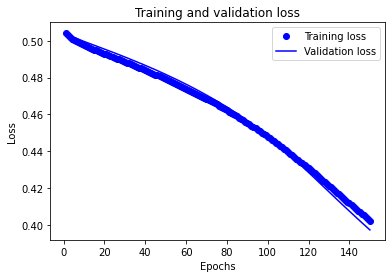

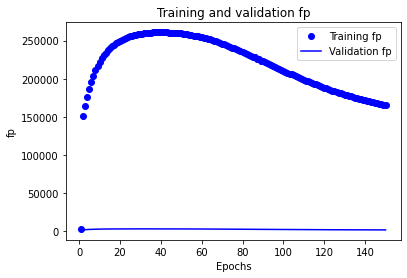

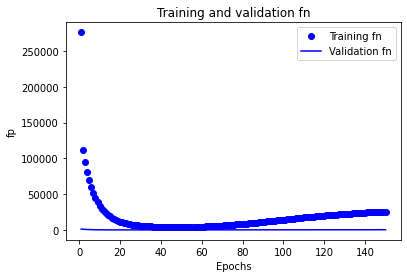

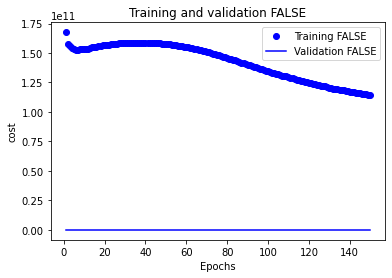

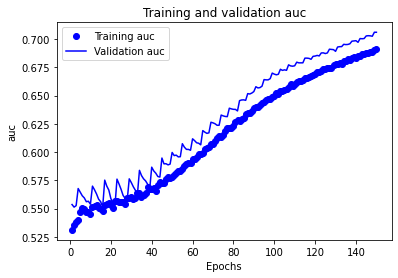

-----
step = 1
cost of false postive 1169298634.8799999
cost of false negative 169524341.01999998
number of false negative 283.0
-----
-----
cost total =  1338822975.8999999
-----
percentage of cost that is false positive 87.33780760626398
-----
percentage of cost that is false negative 12.662192393736017


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


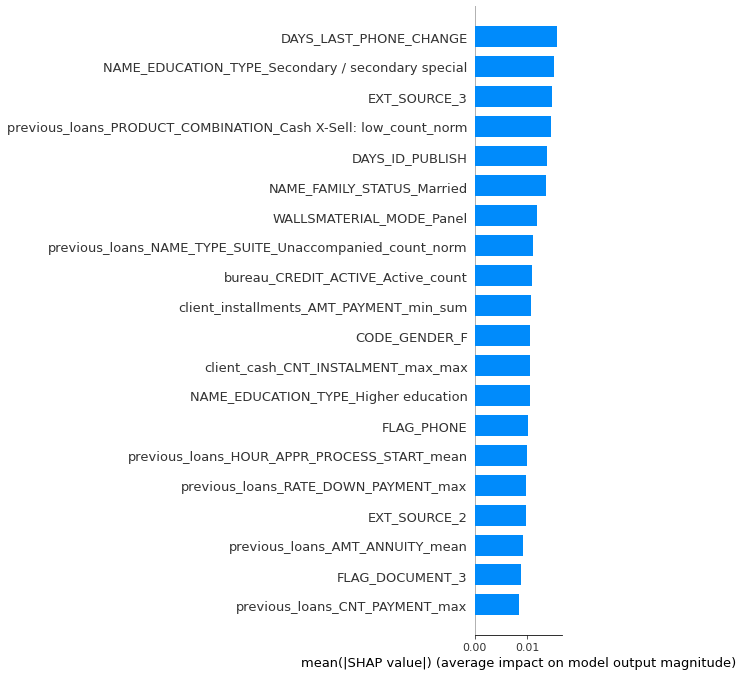

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_14 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_15 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_16 (Dropout)         (None, 8)                

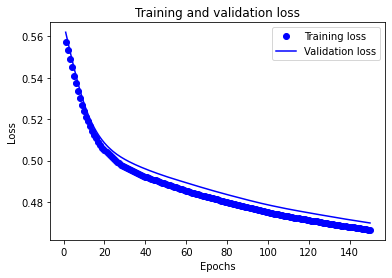

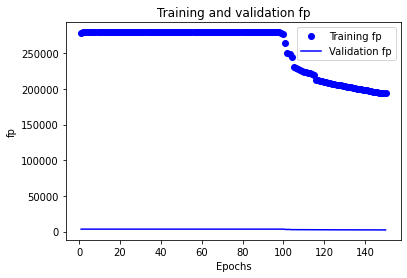

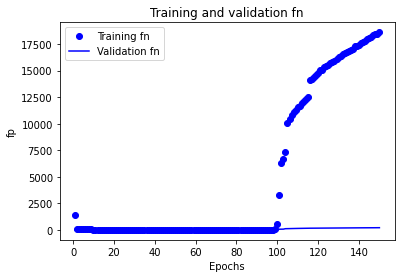

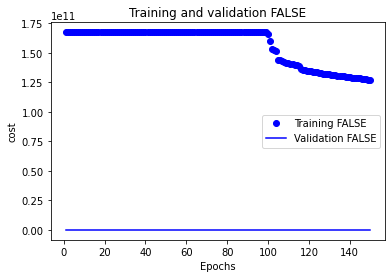

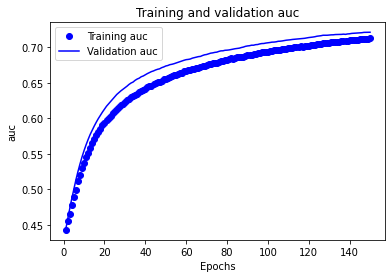

-----
step = 2
cost of false postive 1405314855.2399998
cost of false negative 125196421.46
number of false negative 209.0
-----
-----
cost total =  1530511276.6999998
-----
percentage of cost that is false positive 91.81996086105674
-----
percentage of cost that is false negative 8.180039138943249


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


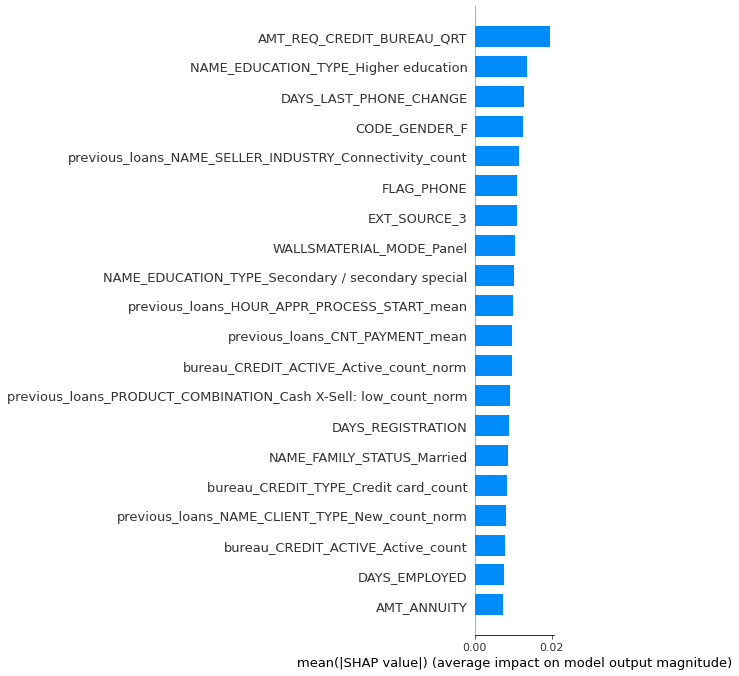

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_18 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_19 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_35 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_20 (Dropout)         (None, 8)                

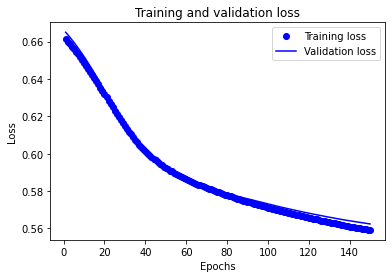

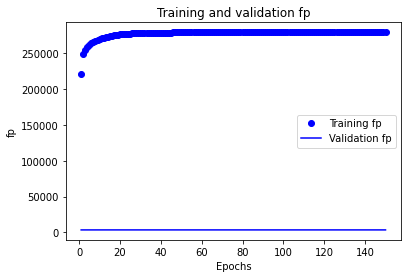

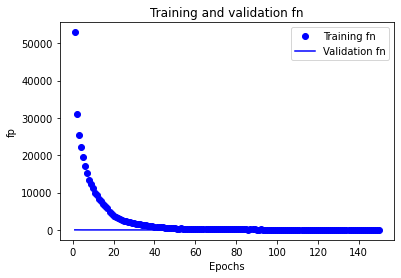

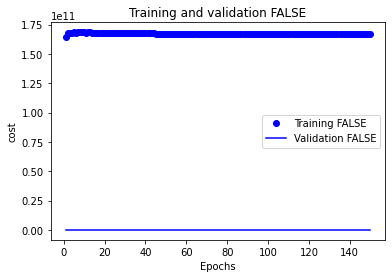

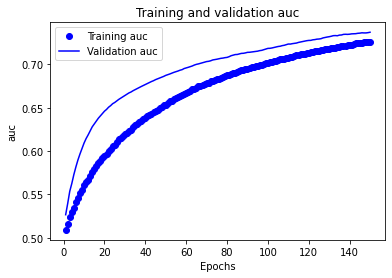

-----
step = 3
cost of false postive 2058253129.84
cost of false negative 0.0
number of false negative 0.0
-----
-----
cost total =  2058253129.84
-----
percentage of cost that is false positive 100.0
-----
percentage of cost that is false negative 0.0


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


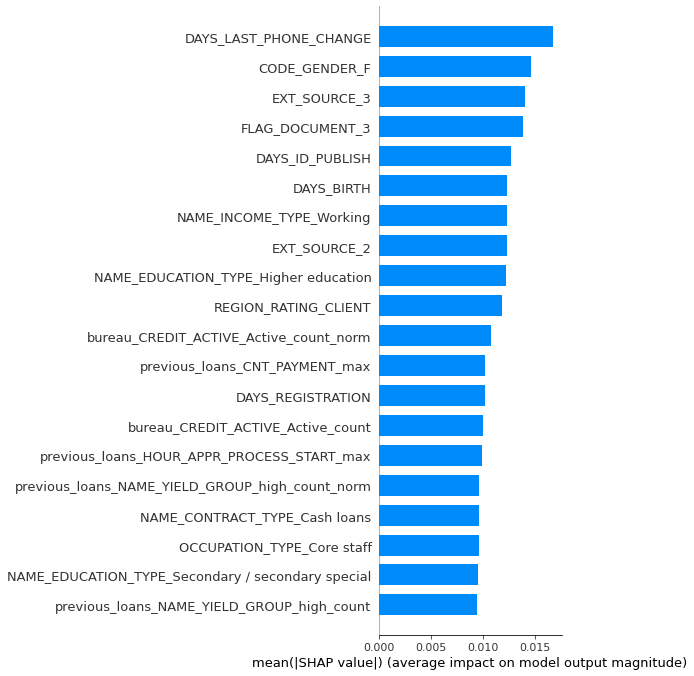

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_22 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_23 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_40 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_41 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_24 (Dropout)         (None, 8)                

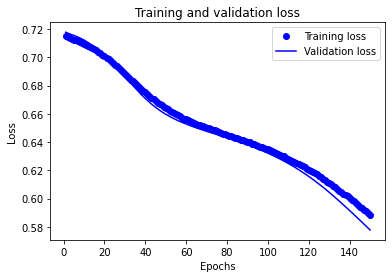

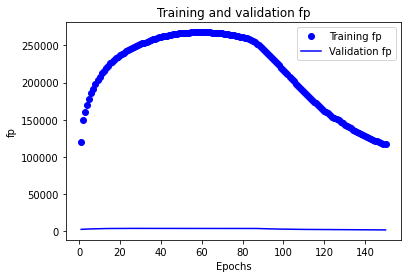

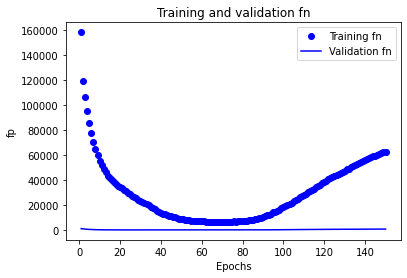

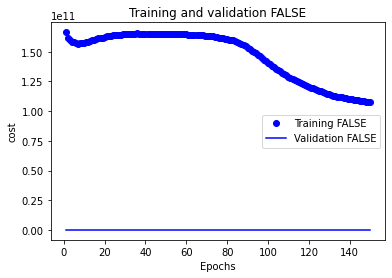

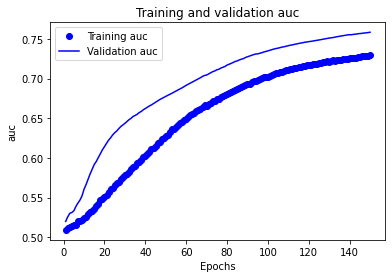

-----
step = 4
cost of false postive 832646056.5999999
cost of false negative 403144457.61999995
number of false negative 673.0
-----
-----
cost total =  1235790514.2199998
-----
percentage of cost that is false positive 67.37760542898691
-----
percentage of cost that is false negative 32.62239457101309


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


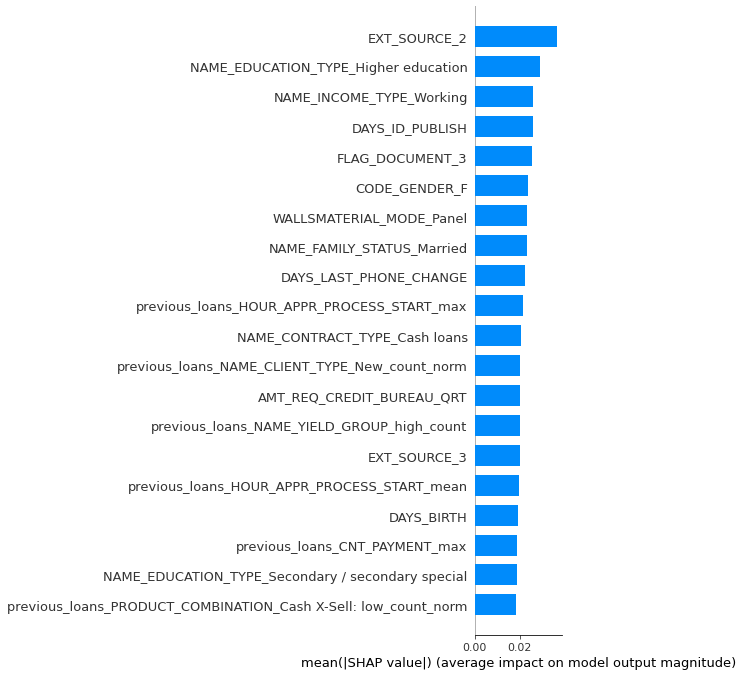

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_26 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_27 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_46 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_47 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_28 (Dropout)         (None, 8)                

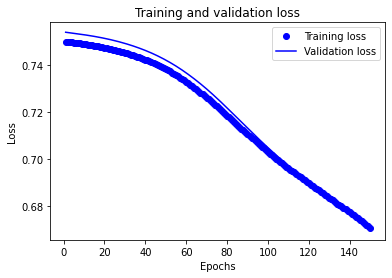

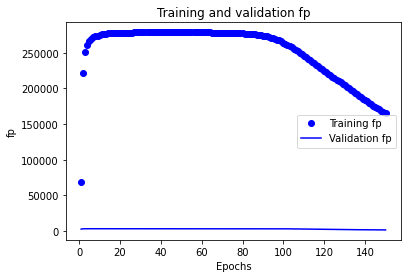

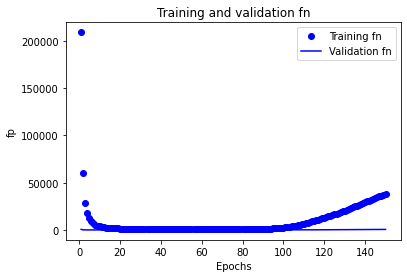

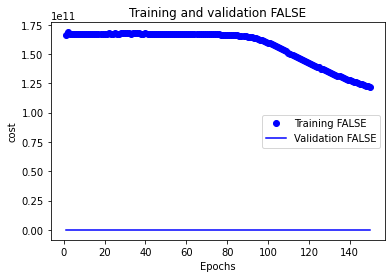

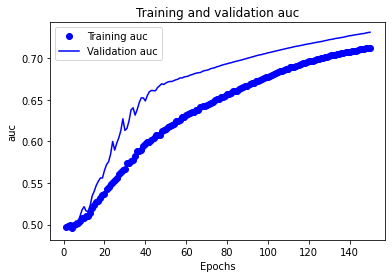

-----
step = 5
cost of false postive 1063870069.4399999
cost of false negative 312691540.67999995
number of false negative 522.0
-----
-----
cost total =  1376561610.12
-----
percentage of cost that is false positive 77.2845953002611
-----
percentage of cost that is false negative 22.7154046997389


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


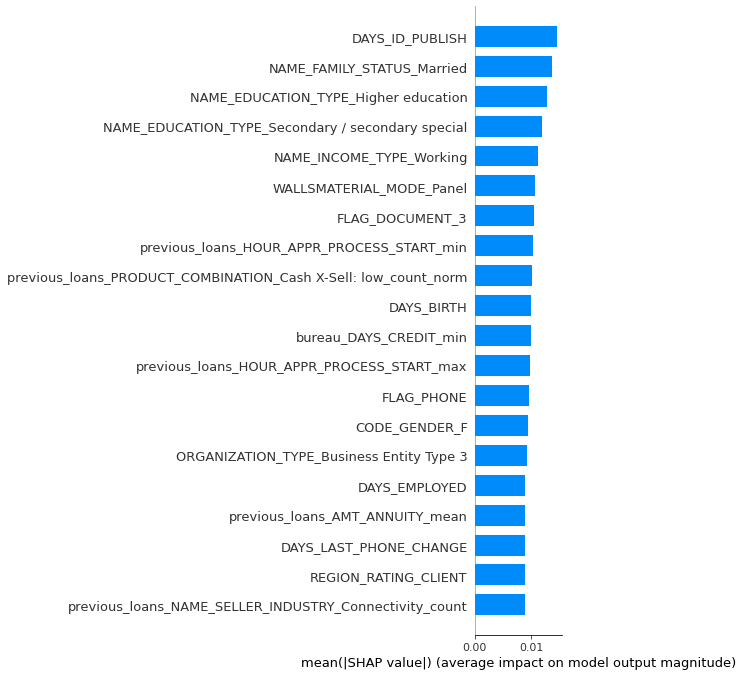

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_30 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_31 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_52 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_53 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_32 (Dropout)         (None, 8)               

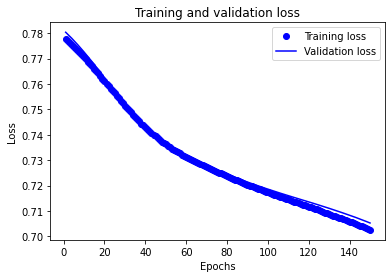

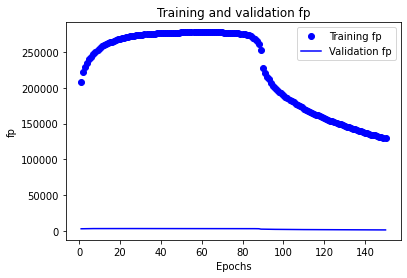

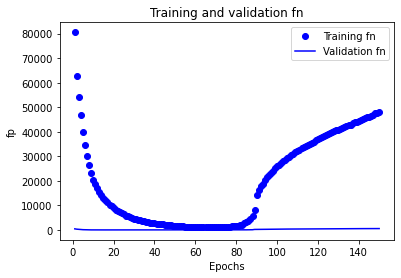

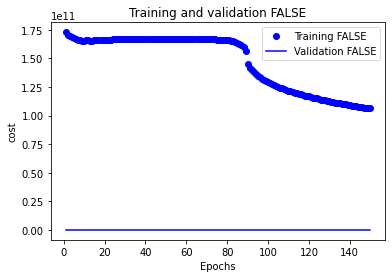

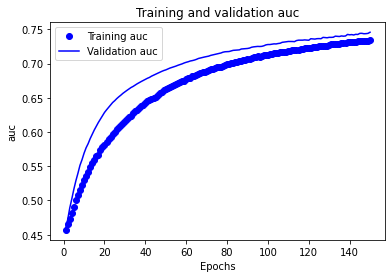

-----
step = 6
cost of false postive 922499947.5999999
cost of false negative 328865241.05999994
number of false negative 549.0
-----
-----
cost total =  1251365188.6599998
-----
percentage of cost that is false positive 73.71948300622307
-----
percentage of cost that is false negative 26.280516993776924


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


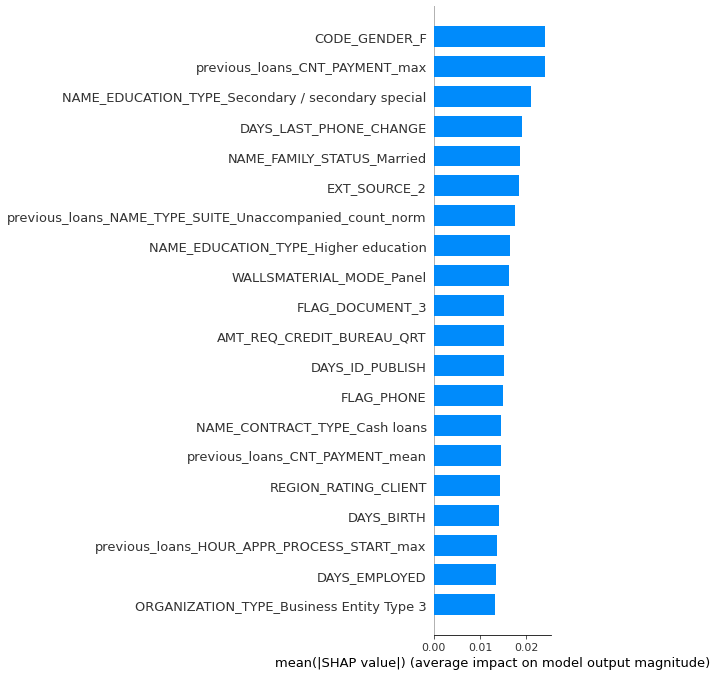

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_34 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_35 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_58 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_59 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_36 (Dropout)         (None, 8)               

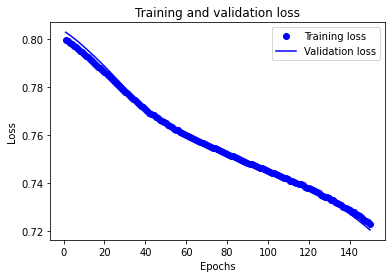

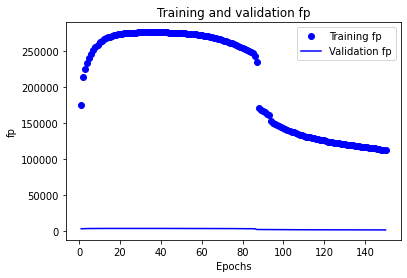

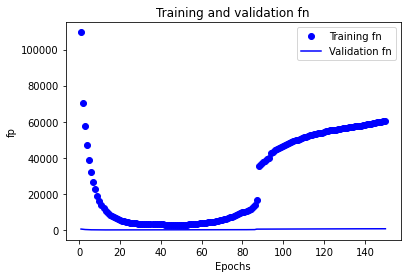

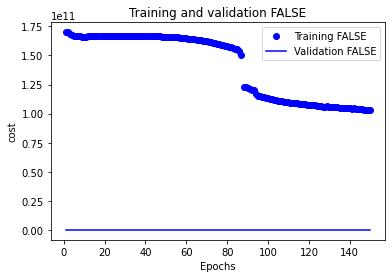

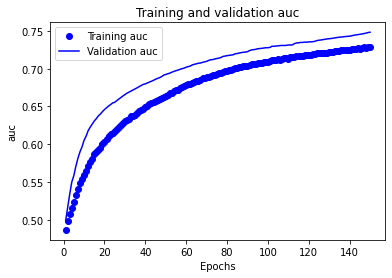

-----
step = 7
cost of false postive 816472356.2199999
cost of false negative 389965886.93999994
number of false negative 651.0
-----
-----
cost total =  1206438243.1599998
-----
percentage of cost that is false positive 67.67626613704071
-----
percentage of cost that is false negative 32.32373386295928


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


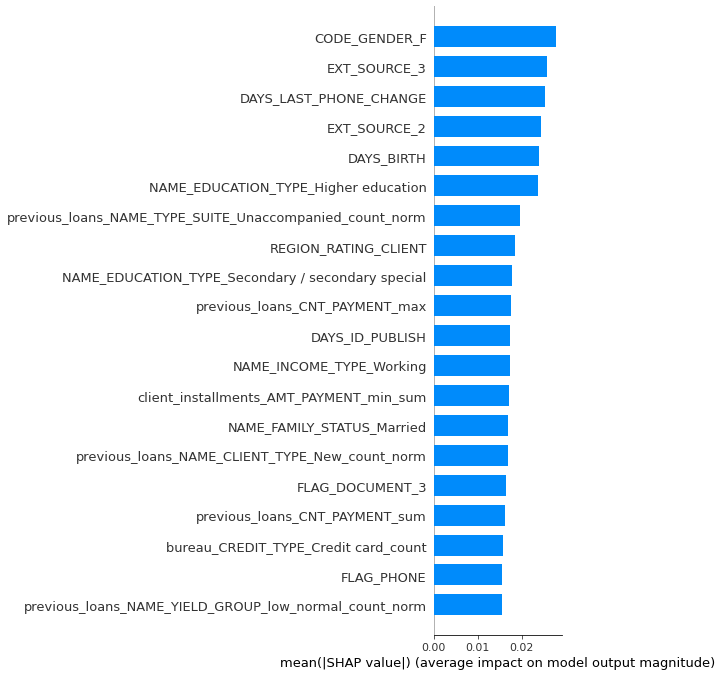

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_38 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_39 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_64 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_65 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_40 (Dropout)         (None, 8)               

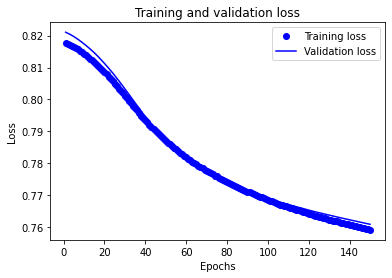

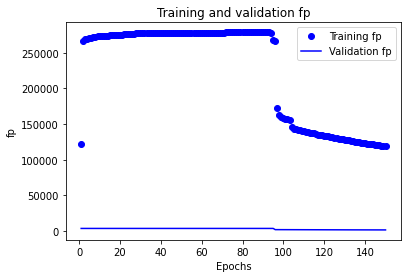

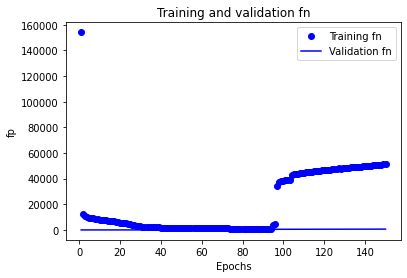

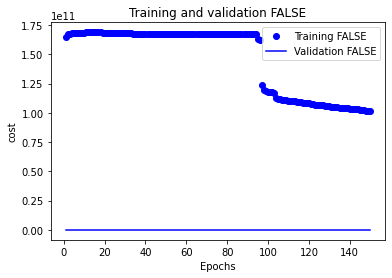

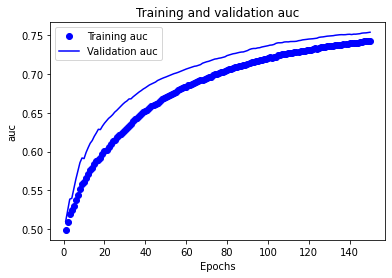

-----
step = 8
cost of false postive 810482096.8199999
cost of false negative 368400953.09999996
number of false negative 615.0
-----
-----
cost total =  1178883049.9199998
-----
percentage of cost that is false positive 68.75000000000001
-----
percentage of cost that is false negative 31.250000000000004


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


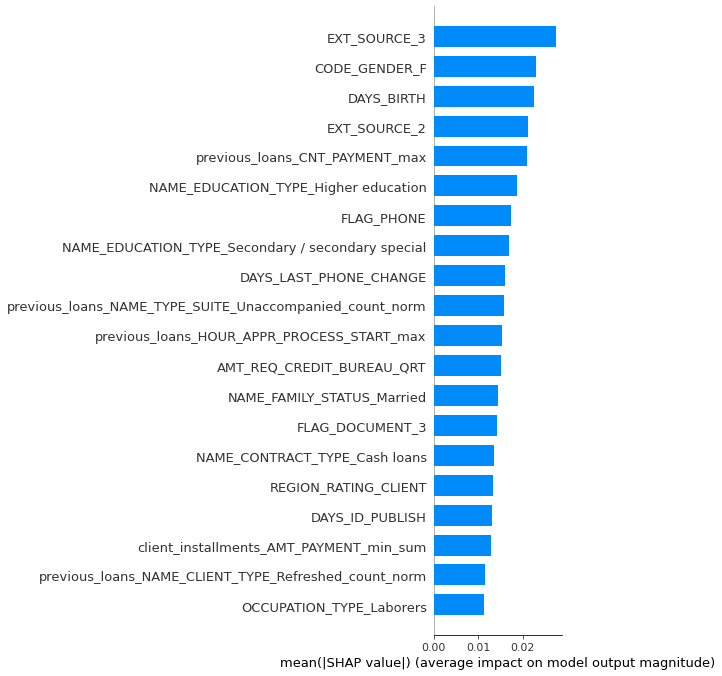

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_42 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_43 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_70 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_71 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_44 (Dropout)         (None, 8)               

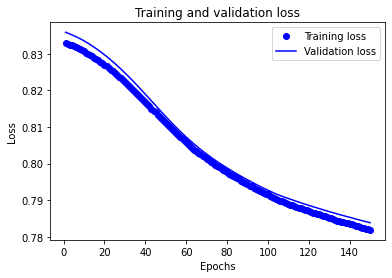

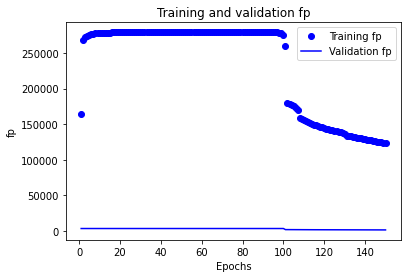

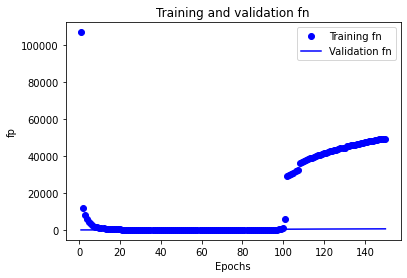

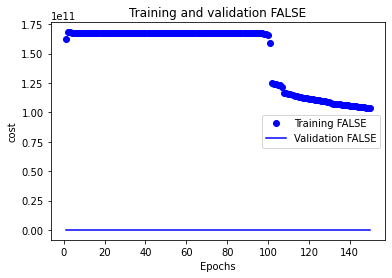

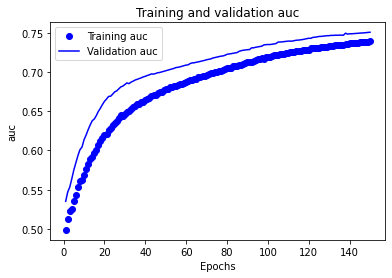

-----
step = 9
cost of false postive 881167157.7399999
cost of false negative 349831148.96
number of false negative 584.0
-----
-----
cost total =  1230998306.6999998
-----
percentage of cost that is false positive 71.58150851581509
-----
percentage of cost that is false negative 28.41849148418492


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


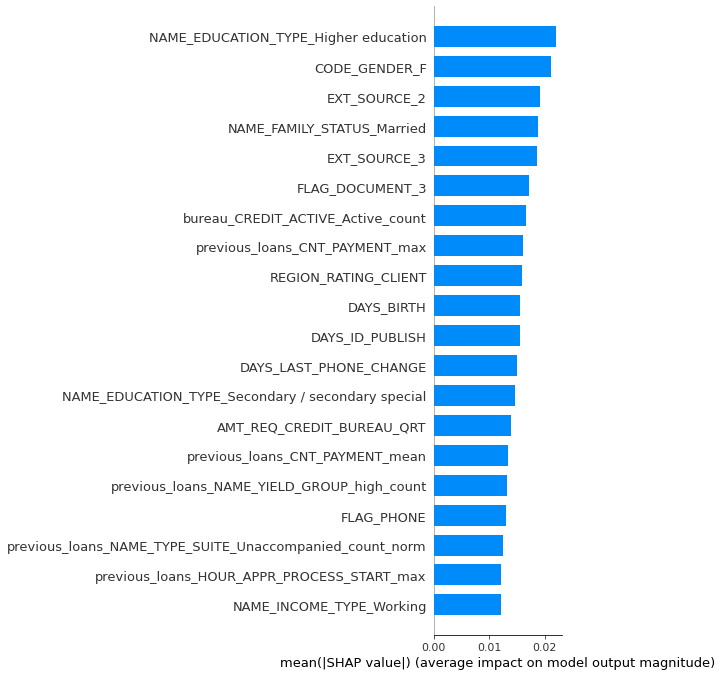

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_46 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_47 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_76 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_77 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_48 (Dropout)         (None, 8)               

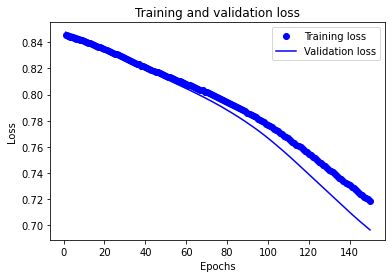

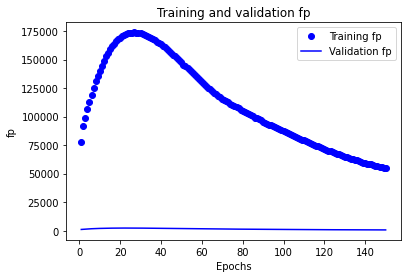

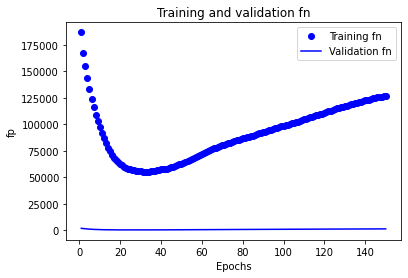

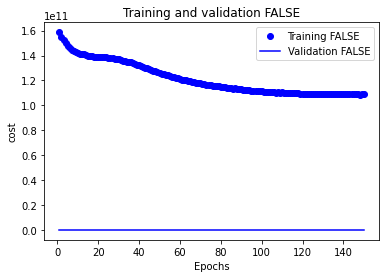

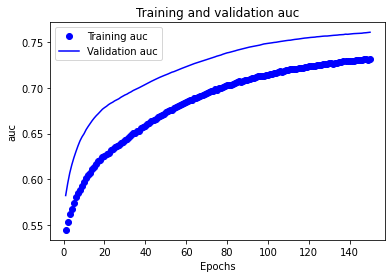

-----
step = 10
cost of false postive 394758094.46
cost of false negative 842230471.6399999
number of false negative 1406.0
-----
-----
cost total =  1236988566.1
-----
percentage of cost that is false positive 31.912832929782084
-----
percentage of cost that is false negative 68.08716707021792


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


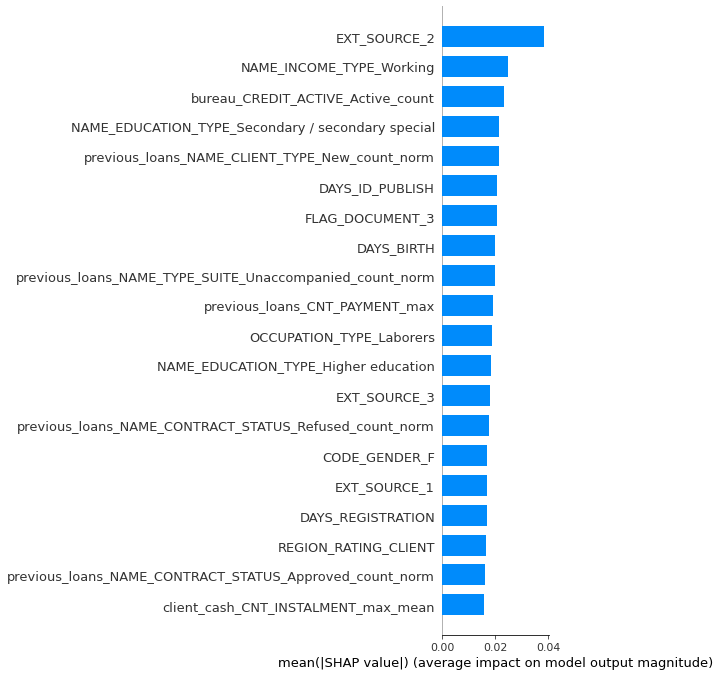

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_50 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_81 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_51 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_82 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_83 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_52 (Dropout)         (None, 8)               

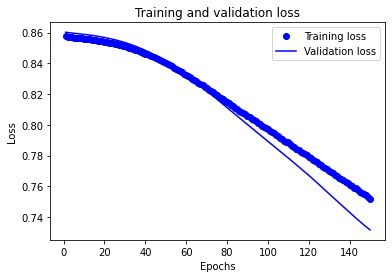

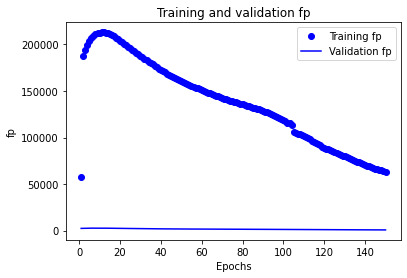

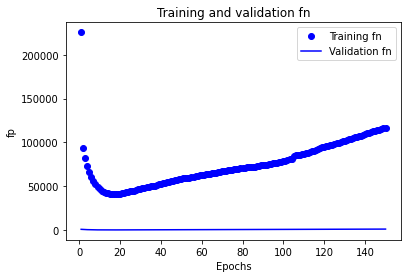

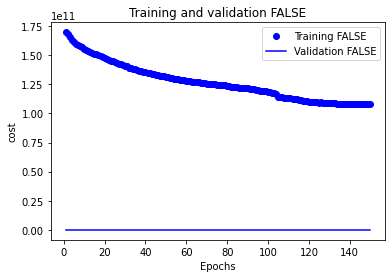

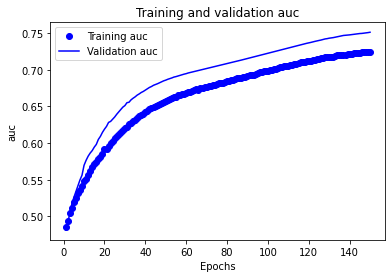

-----
step = 11
cost of false postive 461848999.73999995
cost of false negative 806288915.2399999
number of false negative 1346.0
-----
-----
cost total =  1268137914.9799998
-----
percentage of cost that is false positive 36.41946150212565
-----
percentage of cost that is false negative 63.58053849787435


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


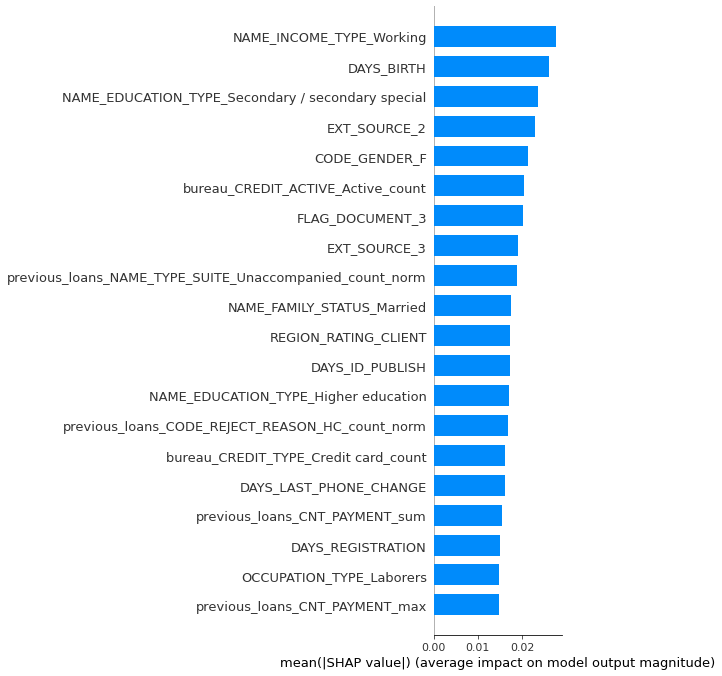

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_54 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_87 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_55 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_88 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_89 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_56 (Dropout)         (None, 8)               

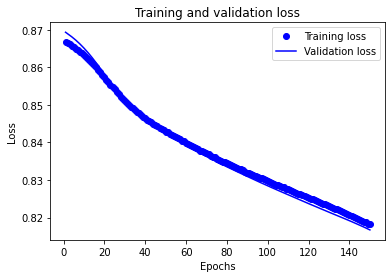

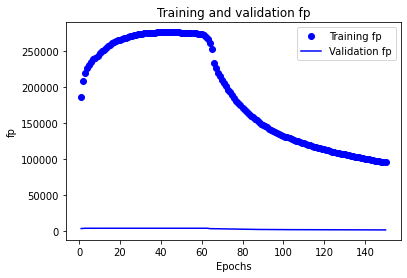

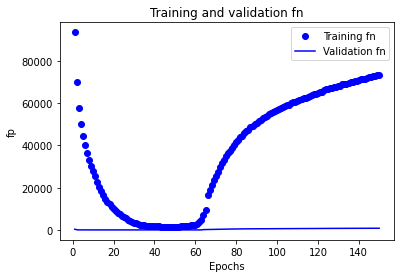

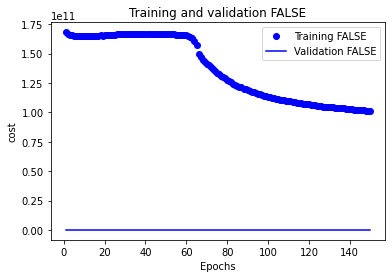

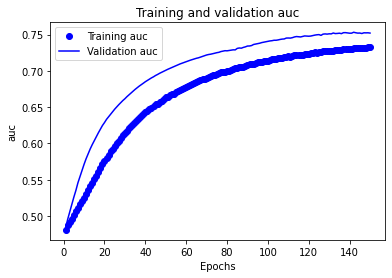

-----
step = 12
cost of false postive 672107104.68
cost of false negative 476225622.29999995
number of false negative 795.0
-----
-----
cost total =  1148332726.98
-----
percentage of cost that is false positive 58.528951486697956
-----
percentage of cost that is false negative 41.47104851330203


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


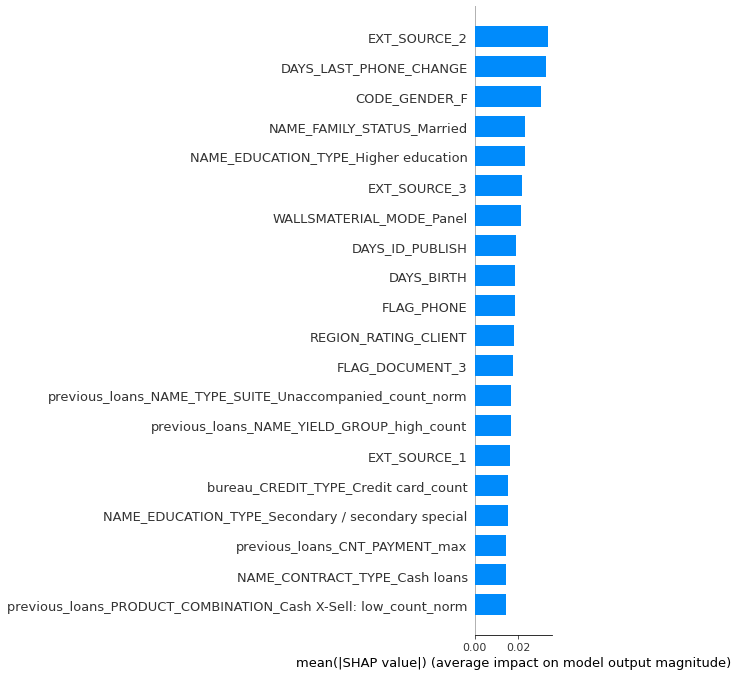

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_58 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_93 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_59 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_94 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_95 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_60 (Dropout)         (None, 8)               

KeyboardInterrupt: 

In [8]:
shap.initjs()
main_thing(20)

In [7]:

def main_thing_2(coefficient_de_poids):    
    shap.initjs()
    train = pd.read_csv(
        "/kaggle/input/home-credit-manual-engineered-features/m_train_small.csv"
    ).astype("float32")
    from sklearn.impute import SimpleImputer
    target = train["TARGET"]
    X_train = train.drop(columns = ["TARGET"])
    imputer = SimpleImputer()
    X_train = imputer.fit_transform(X_train)
    from keras import backend as K
    import tensorflow as tf
    import keras
    from keras import layers
    from keras import models


    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    from sklearn.decomposition import PCA


    from imblearn.over_sampling import SMOTE

    std_scaler = StandardScaler()
    X_train = std_scaler.fit_transform(X_train)
    #pca = PCA(n_components = 250)
    sm = SMOTE()
    X_train, y_train = sm.fit_resample(X_train, target)


    #X_train = pca.fit_transform(X_train)

    #print(pca.explained_variance_ratio_.cumsum())





    #pca = PCA(n_components = 50)

    #X_train = pca.fit_transform(X_train)
    #X_train = umap.UMAP(n_components=250).fit_transform(X_train)
    X_train, X_test, y_train, y_test = train_test_split(
        X_train,
        y_train,
        test_size=0.012) # Argued by https://www.ncbi.nlm.nih.gov/pubmed/18255701 as optimal value in this case
    #X_train, y_train = sm.fit_resample(X_train, y_train)
    counts = np.bincount(y_train)
    print(
        "Number of positive samples in training data: {} ({:.2f}% of total)".format(
            counts[1], 100 * float(counts[1]) / len(y_train)
        )
    )

    weight_for_0 = 1.0 / counts[0]
    weight_for_1 = 1.0 / counts[1]
    from tensorflow.keras import regularizers
    for indice in range(1, coefficient_de_poids, 10):
        model = keras.Sequential(
            [
                keras.layers.Dense(16, activation="relu", input_shape=(X_train.shape[-1],)),
                keras.layers.Dropout(0.1),
                keras.layers.Dense(8, activation="relu"),
                keras.layers.Dropout(0.1),
                keras.layers.Dense(4, activation="relu"),
                keras.layers.Dense(8, activation="relu"),
                keras.layers.Dropout(0.1),
                keras.layers.Dense(16, activation="relu"),
                keras.layers.Dropout(0.1),
                keras.layers.Dense(1, activation="sigmoid"),
            ]
        )
        model.summary()
        def f1(y_true, y_pred):
            y_pred = K.round(y_pred)
            tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
            tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
            fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)*indice
            fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

            p = tp / (tp + fp + K.epsilon())
            r = tp / (tp + fn + K.epsilon())

            f1 = 2*p*r / (p+r+K.epsilon())
            f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
            return K.mean(f1)
        def FALSE(y_true, y_pred):
            y_pred = K.round(y_pred)
            fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
            fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
            return (fp+fn)*599025

        def f1_loss(y_true, y_pred):

            tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
            tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
            fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)*indice
            fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

            p = tp / (tp + fp + K.epsilon())
            r = tp / (tp + fn + K.epsilon())

            f1 = 2*p*r / (p+r+K.epsilon())
            f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
            return 1 - K.mean(f1)

        metrics = [tf.keras.metrics.FalseNegatives(name="fn"),
            tf.keras.metrics.FalsePositives(name="fp"),
            tf.keras.metrics.TrueNegatives(name="tn"),
            tf.keras.metrics.TruePositives(name="tp"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name = "auc"),
            f1,
            FALSE
        ]

        model.compile(
            optimizer=tf.keras.optimizers.Adamax(), loss=f1_loss, metrics=[metrics]
        )


        #class_weight = {0: weight_for_0, 1: weight_for_1}

        history = model.fit(
            X_train,
            y_train,
            batch_size=X_train.shape[0],
            epochs=1500,
            validation_data=(X_test, y_test),
            verbose = 0
            #class_weight = class_weight
        )
        def f(X):
            return model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
        import matplotlib.pyplot as plt
        history_dict = history.history
        loss_values = history_dict["loss"]
        val_loss_values = history_dict["val_loss"]
        epochs = range(1, len(loss_values) + 1)
        plt.plot(epochs, loss_values, "bo", label="Training loss")
        plt.plot(epochs, val_loss_values, "b", label="Validation loss")
        plt.title("Training and validation loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        plt.clf()
        acc = history_dict["fp"]
        val_acc_fp = history_dict["val_fp"]
        plt.plot(epochs, acc, "bo", label="Training fp")
        plt.plot(epochs, val_acc_fp, "b", label="Validation fp")
        plt.title("Training and validation fp")
        plt.xlabel("Epochs")
        plt.ylabel("fp")
        plt.legend()
        plt.show()
        plt.clf()
        acc = history_dict["fn"]
        val_acc_fn = history_dict["val_fn"]
        plt.plot(epochs, acc, "bo", label="Training fn")
        plt.plot(epochs, val_acc_fn, "b", label="Validation fn")
        plt.title("Training and validation fn")
        plt.xlabel("Epochs")
        plt.ylabel("fp")
        plt.legend()
        plt.show()
        acc = history_dict["FALSE"]
        val_acc_false = history_dict["val_FALSE"]
        plt.plot(epochs, acc, "bo", label="Training FALSE")
        plt.plot(epochs, val_acc_fn, "b", label="Validation FALSE")
        plt.title("Training and validation FALSE")
        plt.xlabel("Epochs")
        plt.ylabel("cost")
        plt.legend()
        plt.show()
        acc = history_dict["auc"]
        val_acc = history_dict["val_auc"]
        plt.plot(epochs, acc, "bo", label="Training auc")
        plt.plot(epochs, val_acc, "b", label="Validation auc")
        plt.title("Training and validation auc")
        plt.xlabel("Epochs")
        plt.ylabel("auc")
        plt.legend()
        plt.show()
        print("-----")
        print("step =", indice)
        print("cost of false postive", val_acc_fp[-1]*599025.94) # amount moyen de crédit 599025
        print("cost of false negative", val_acc_fn[-1]*599025.94)
        print("number of false negative", val_acc_fn[-1])
        print("-----")
        print("-----")
        print("cost total = " , val_acc_fp[-1]*599025.94 + val_acc_fn[-1]*599025.94)
        print("-----")
        print("percentage of cost that is false positive", (val_acc_fp[-1]*599025.94*100)/(val_acc_fp[-1]*599025.94 + val_acc_fn[-1]*599025.94))
        print("-----")
        print("percentage of cost that is false negative", (val_acc_fn[-1]*599025.94*100)/(val_acc_fp[-1]*599025.94 + val_acc_fn[-1]*599025.94))
        test = pd.read_csv("/kaggle/input/home-credit-manual-engineered-features/m_test_small.csv")
        test = imputer.transform(test)
        
        test = std_scaler.transform(test)
        #test = pca.transform(test)

        test_model = model.predict(test)
        submit = pd.read_csv("/kaggle/input/test-imputed-credit-score/test_imputed.csv")[['SK_ID_CURR']]
        submit['TARGET'] = test_model
        X_train_features = pd.DataFrame(X_train, columns = train.drop(columns = ["TARGET"]).columns) 
        submit.to_csv("test_model_NN{}.csv".format(indice), index = False)
        explainer = shap.DeepExplainer(model, X_test[:500,:])
        shap_values = explainer.shap_values( X_test[:50,:])
        #shap.force_plot(explainer.expected_value, shap_values[-1],  X_train_features.iloc[280:330,:])
        shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = X_train_features.columns)
        shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names = X_train_features.columns)

Number of positive samples in training data: 279280 (50.00% of total)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                5504      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 40        
__________________________________________________

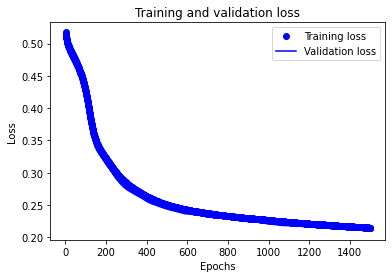

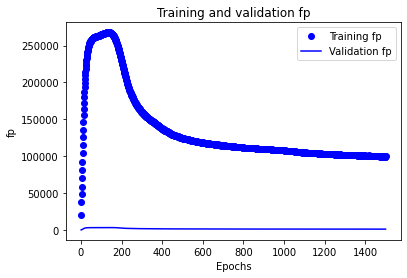

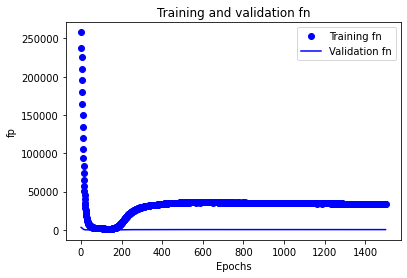

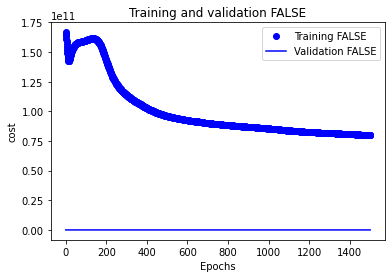

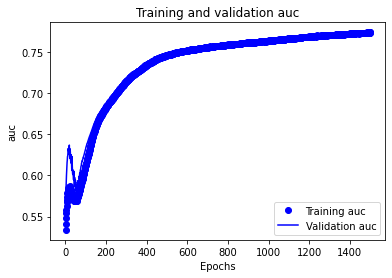

-----
step = 1
cost of false postive 713439894.54
cost of false negative 249793816.98
number of false negative 417.0
-----
-----
cost total =  963233711.52
-----
percentage of cost that is false positive 74.06716417910448
-----
percentage of cost that is false negative 25.932835820895523


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


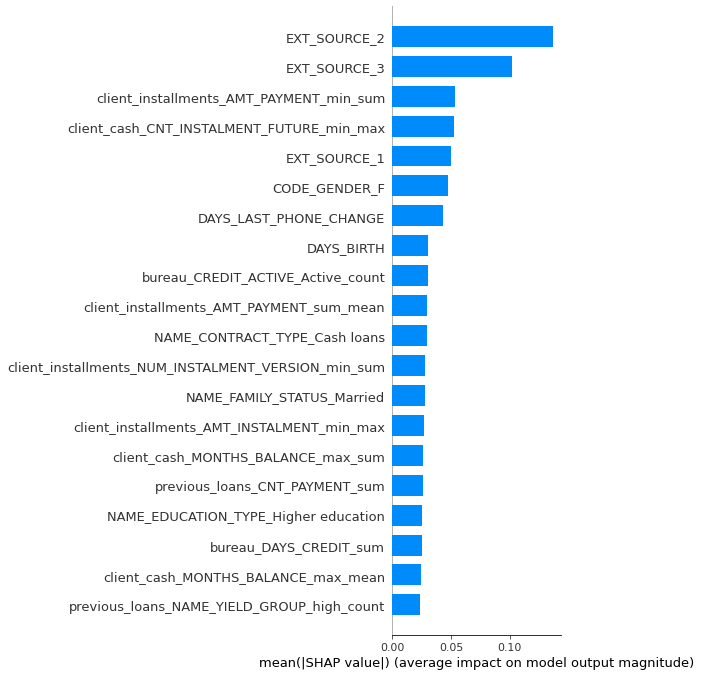

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_9 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_10 (Dropout)         (None, 8)                

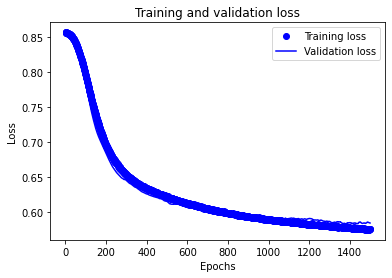

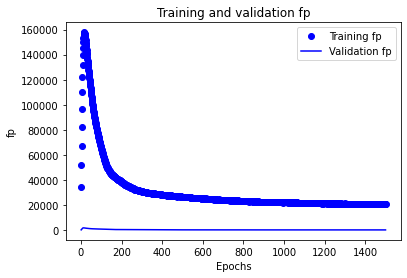

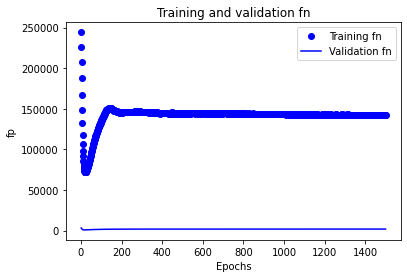

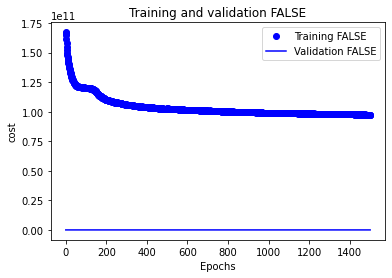

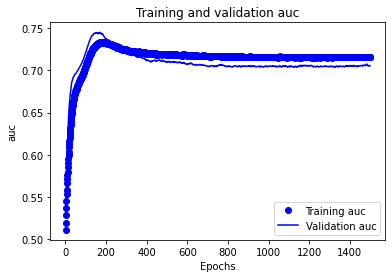

-----
step = 11
cost of false postive 145563303.42
cost of false negative 1084835977.34
number of false negative 1811.0
-----
-----
cost total =  1230399280.76
-----
percentage of cost that is false positive 11.830574488802336
-----
percentage of cost that is false negative 88.16942551119764


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


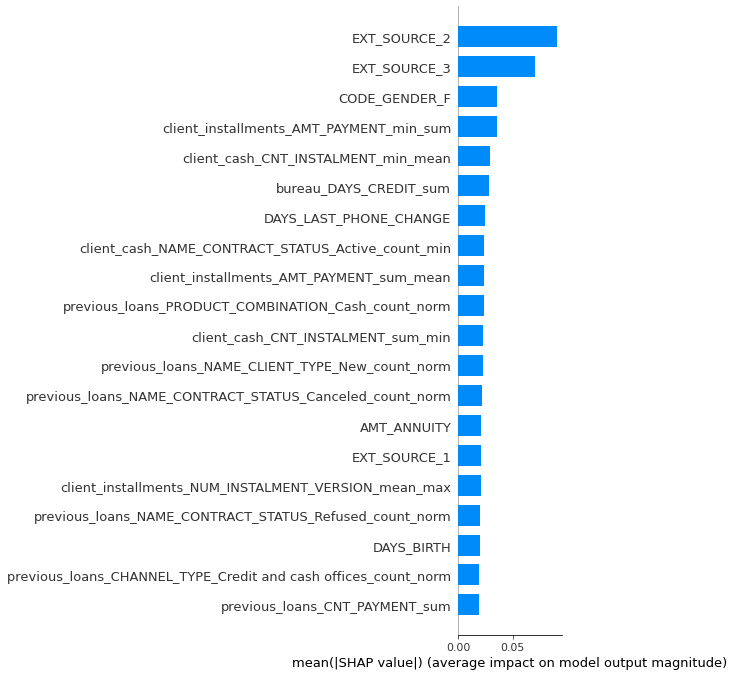

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_13 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_21 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_14 (Dropout)         (None, 8)                

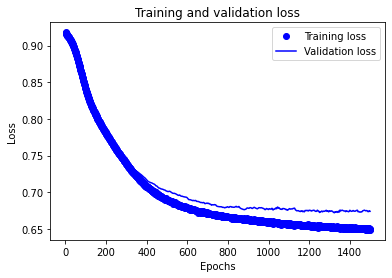

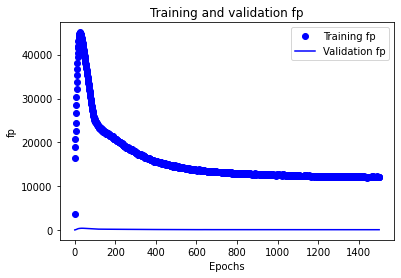

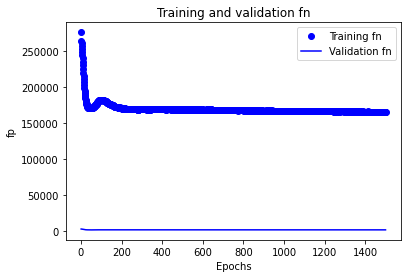

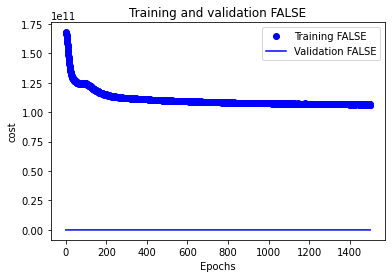

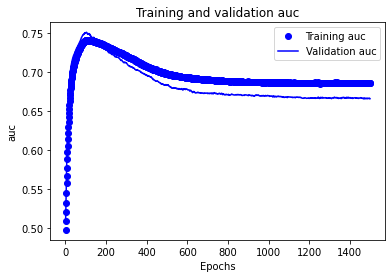

-----
step = 21
cost of false postive 85660709.41999999
cost of false negative 1288504796.9399998
number of false negative 2151.0
-----
-----
cost total =  1374165506.36
-----
percentage of cost that is false positive 6.233653007846556
-----
percentage of cost that is false negative 93.76634699215344


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


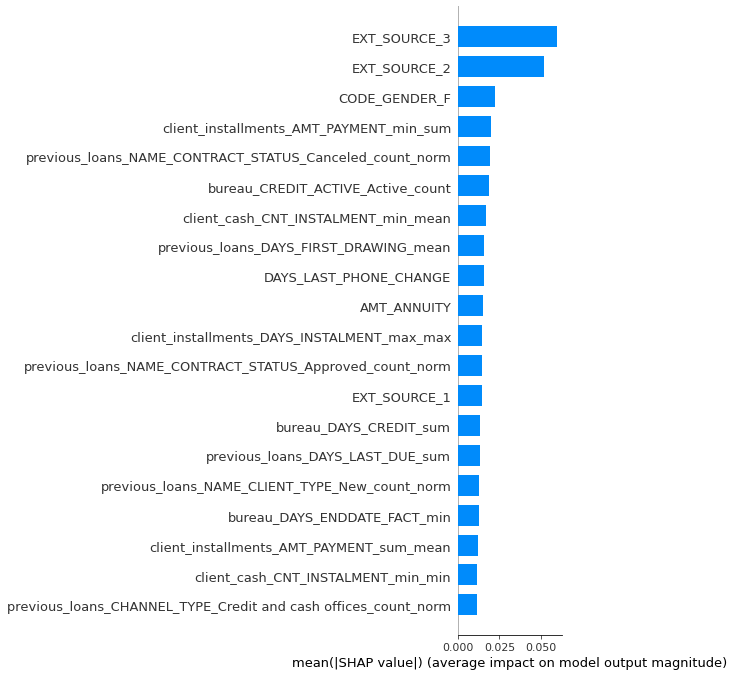

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_16 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_17 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_27 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_18 (Dropout)         (None, 8)                

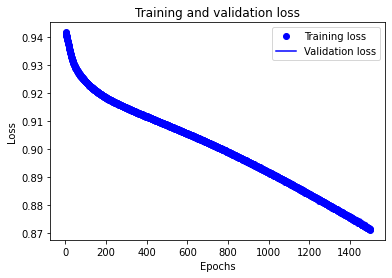

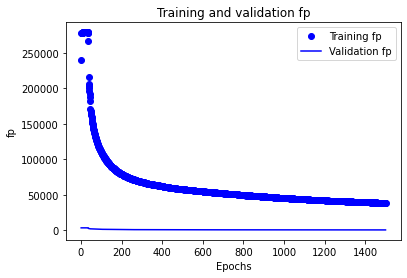

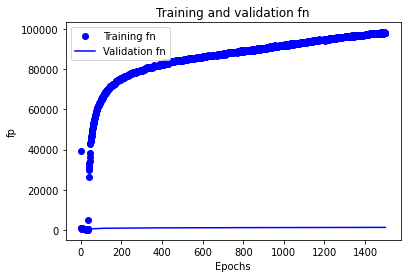

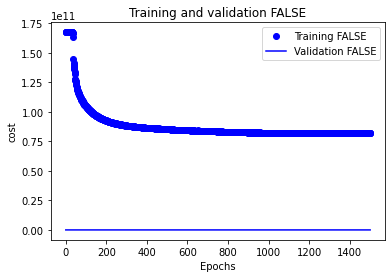

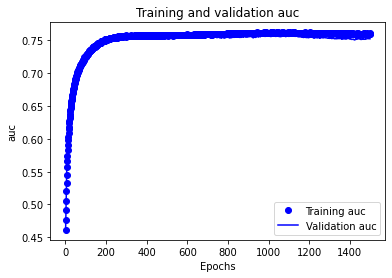

-----
step = 31
cost of false postive 278547062.09999996
cost of false negative 751777554.6999999
number of false negative 1255.0
-----
-----
cost total =  1030324616.8
-----
percentage of cost that is false positive 27.03488372093023
-----
percentage of cost that is false negative 72.96511627906978


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


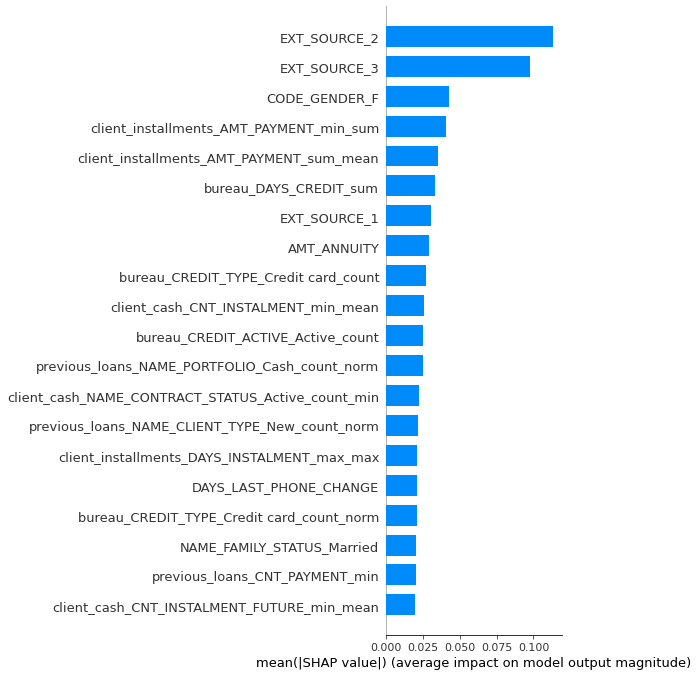

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_20 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_21 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_32 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_33 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_22 (Dropout)         (None, 8)                

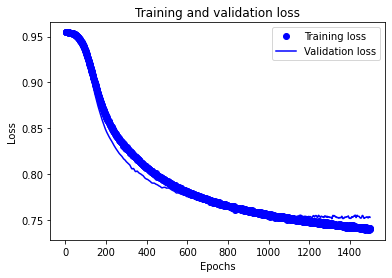

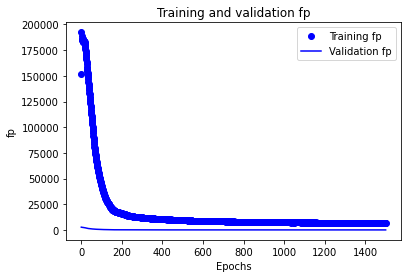

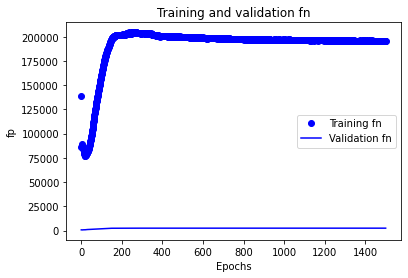

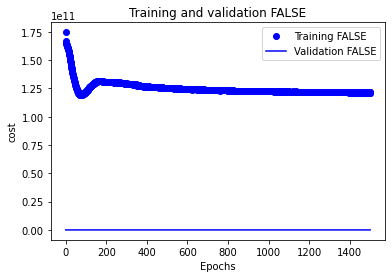

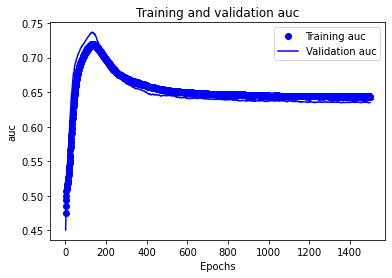

-----
step = 41
cost of false postive 51516230.839999996
cost of false negative 1455034008.2599998
number of false negative 2429.0
-----
-----
cost total =  1506550239.0999997
-----
percentage of cost that is false positive 3.4194831013916507
-----
percentage of cost that is false negative 96.58051689860835


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


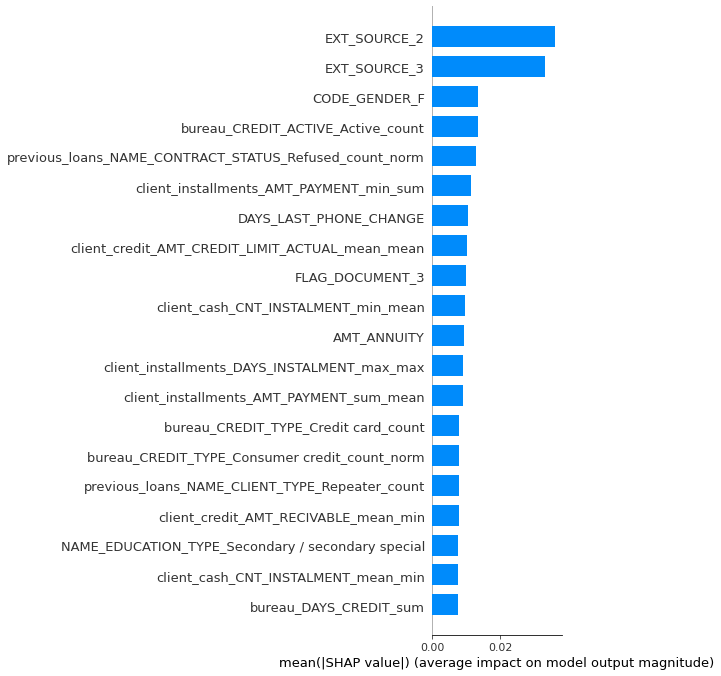

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_24 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_25 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_38 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_39 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_26 (Dropout)         (None, 8)                

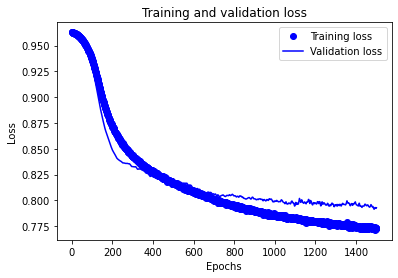

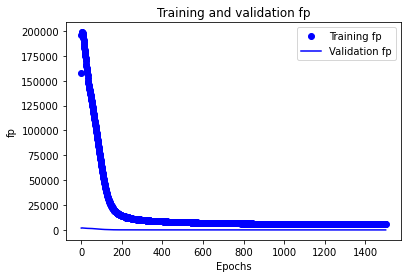

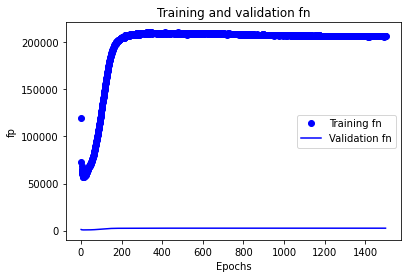

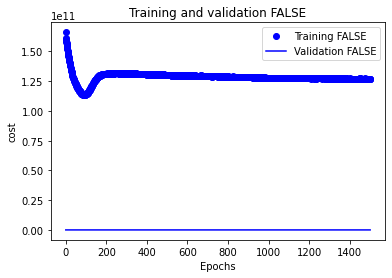

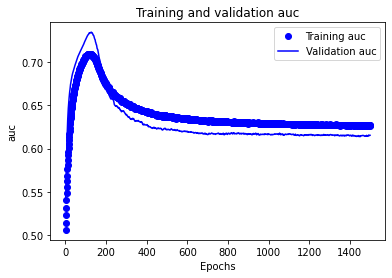

-----
step = 51
cost of false postive 44327919.559999995
cost of false negative 1542491795.4999998
number of false negative 2575.0
-----
-----
cost total =  1586819715.0599997
-----
percentage of cost that is false positive 2.7935069837674593
-----
percentage of cost that is false negative 97.20649301623254


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


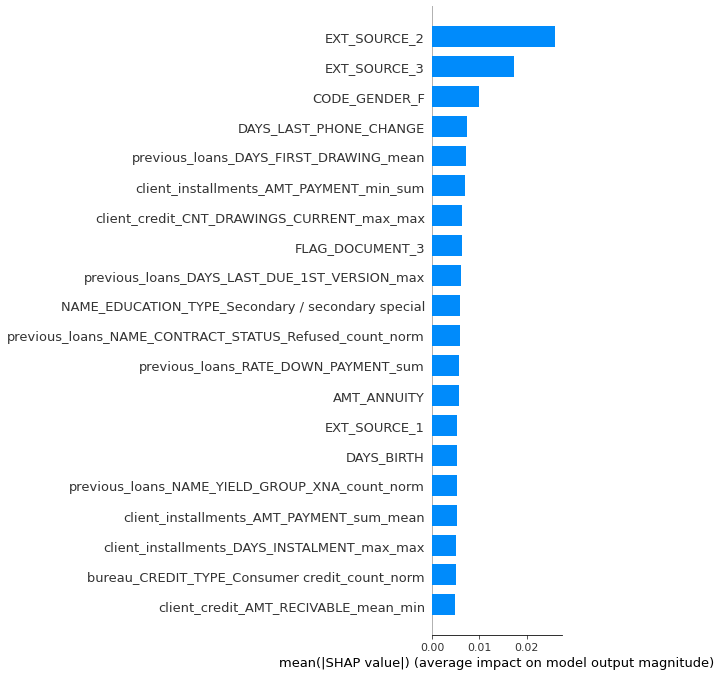

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_28 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_29 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_44 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_45 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_30 (Dropout)         (None, 8)                

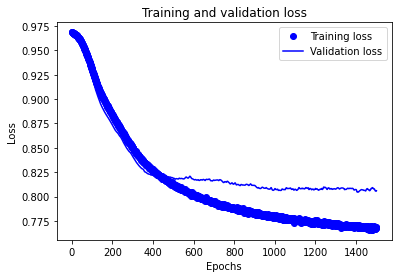

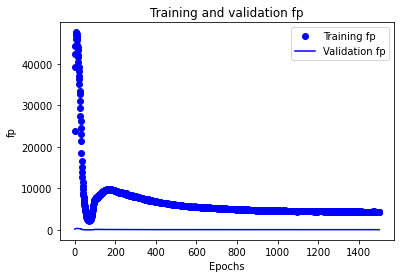

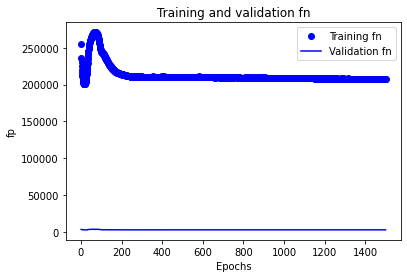

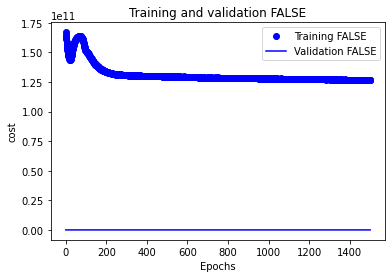

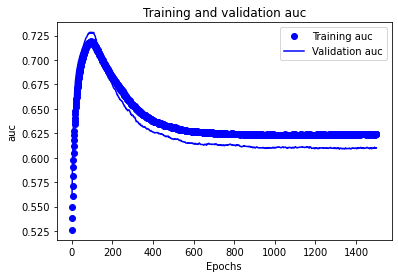

-----
step = 61
cost of false postive 39535712.04
cost of false negative 1564056729.34
number of false negative 2611.0
-----
-----
cost total =  1603592441.3799999
-----
percentage of cost that is false positive 2.4654463952185286
-----
percentage of cost that is false negative 97.53455360478148


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


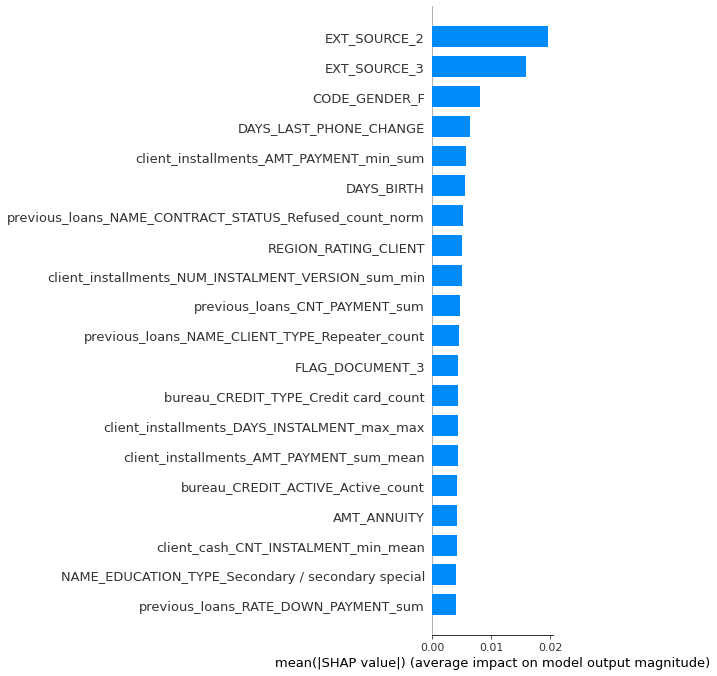

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_32 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_33 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_50 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_51 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_34 (Dropout)         (None, 8)                

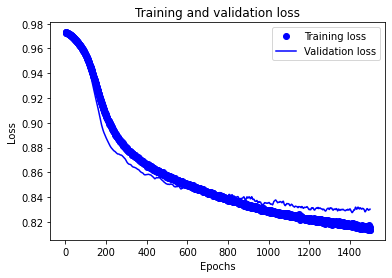

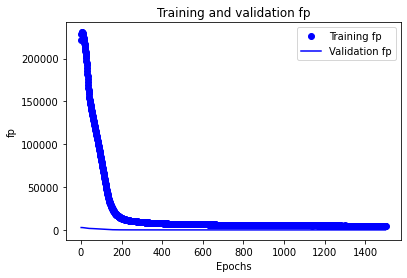

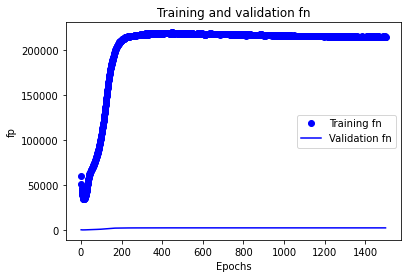

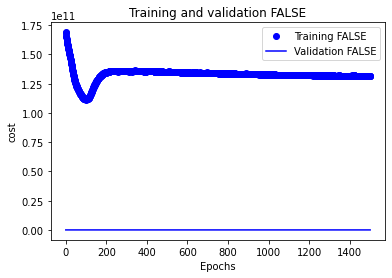

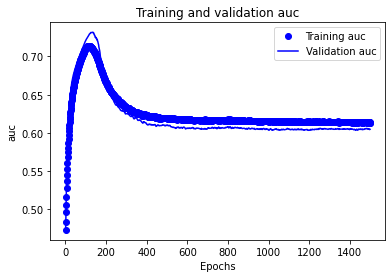

-----
step = 71
cost of false postive 38936686.099999994
cost of false negative 1594008026.34
number of false negative 2661.0
-----
-----
cost total =  1632944712.4399998
-----
percentage of cost that is false positive 2.3844460748349228
-----
percentage of cost that is false negative 97.61555392516509


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


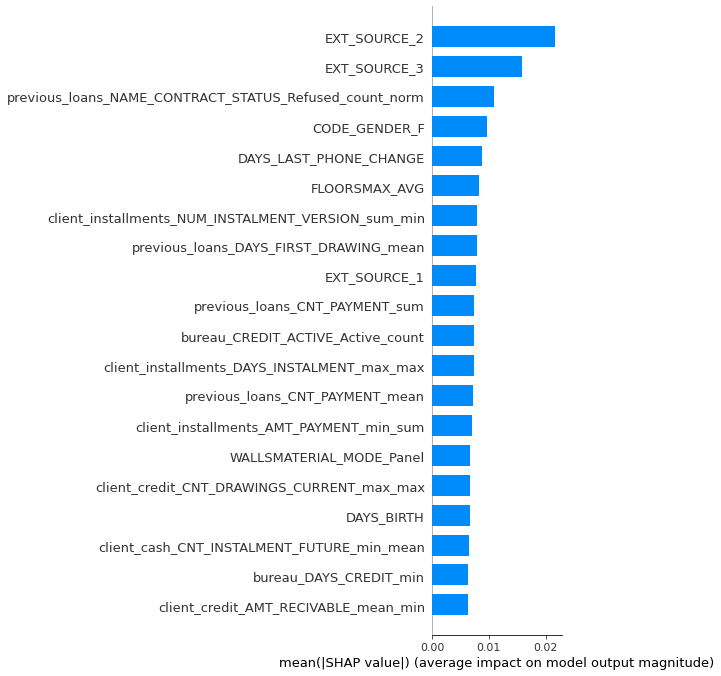

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_36 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_37 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_56 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_57 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_38 (Dropout)         (None, 8)                

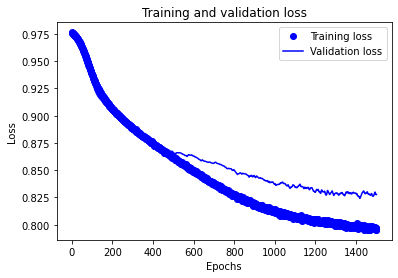

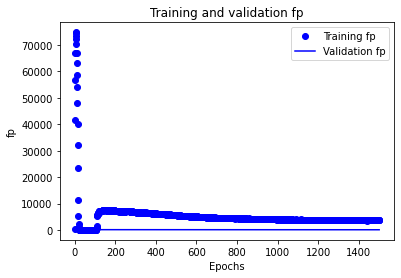

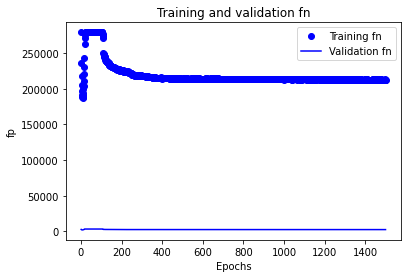

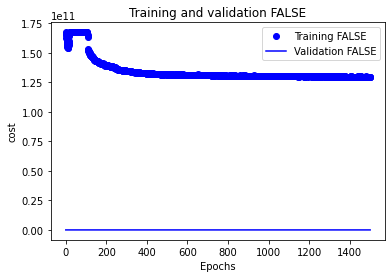

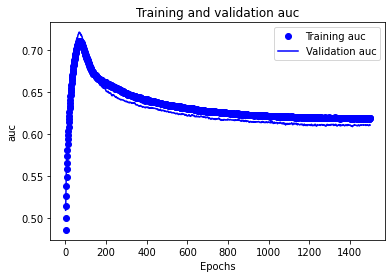

-----
step = 81
cost of false postive 35941556.4
cost of false negative 1568848936.86
number of false negative 2619.0
-----
-----
cost total =  1604790493.26
-----
percentage of cost that is false positive 2.2396416573348263
-----
percentage of cost that is false negative 97.76035834266517


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


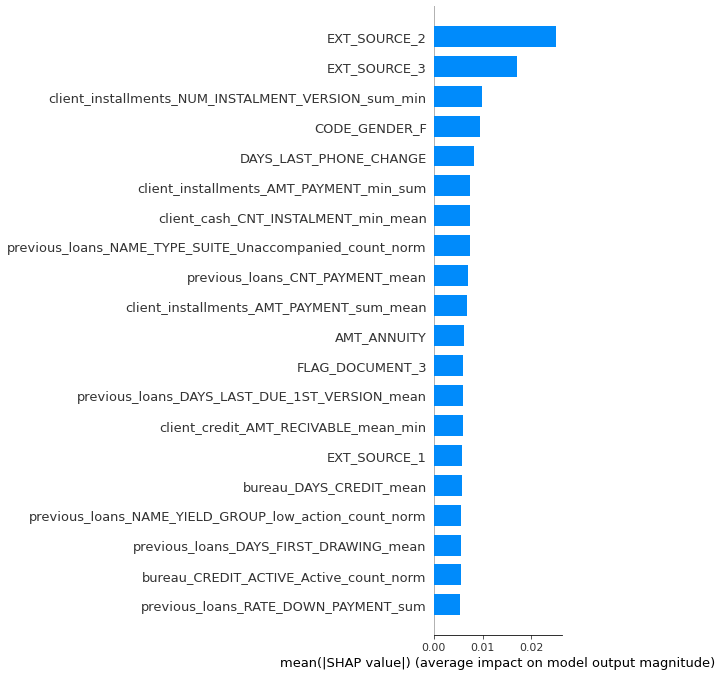

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_40 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_41 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_62 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_63 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_42 (Dropout)         (None, 8)               

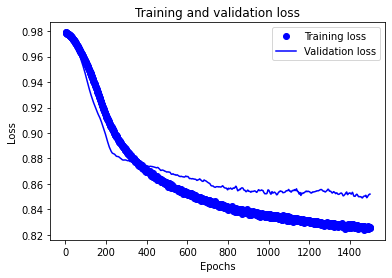

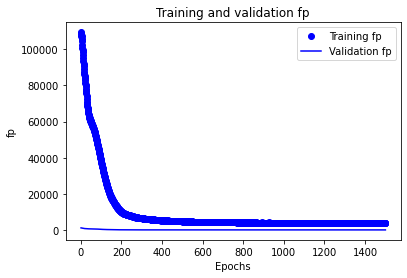

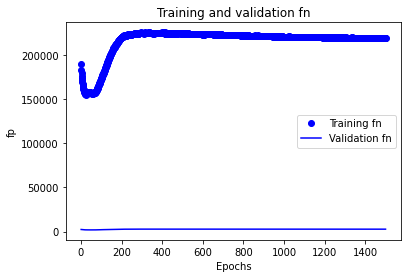

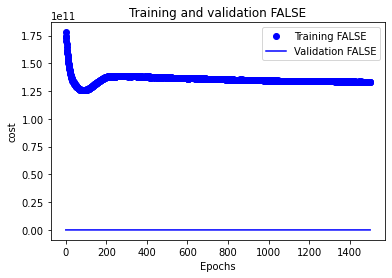

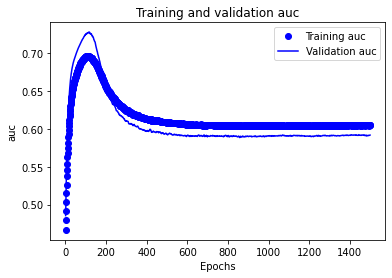

-----
step = 91
cost of false postive 31748374.819999997
cost of false negative 1644326205.3
number of false negative 2745.0
-----
-----
cost total =  1676074580.12
-----
percentage of cost that is false positive 1.8942101501072193
-----
percentage of cost that is false negative 98.10578984989279


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


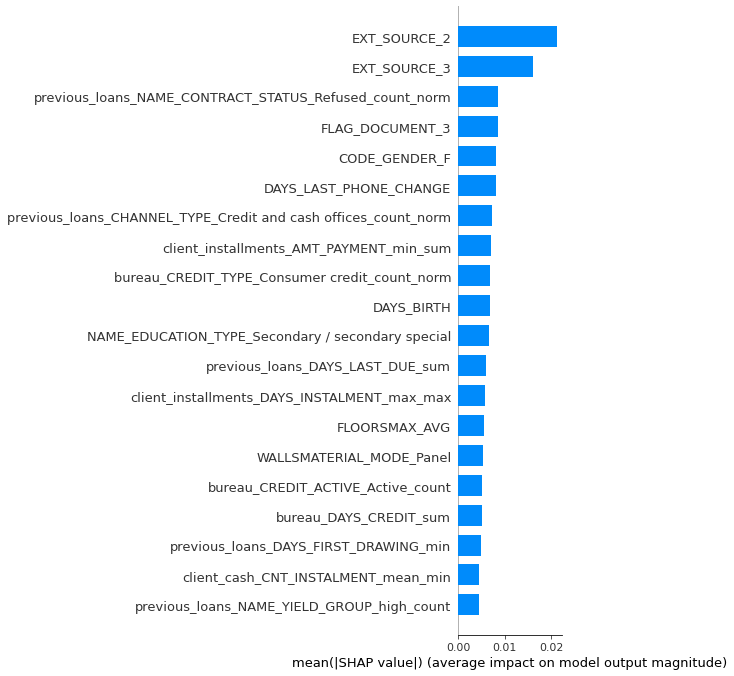

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_44 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_45 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_68 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_69 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_46 (Dropout)         (None, 8)               

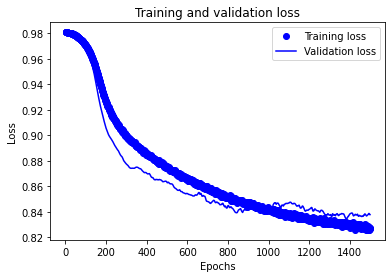

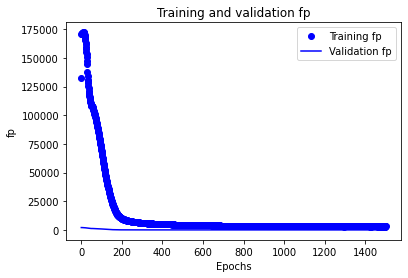

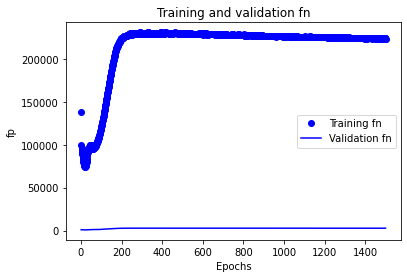

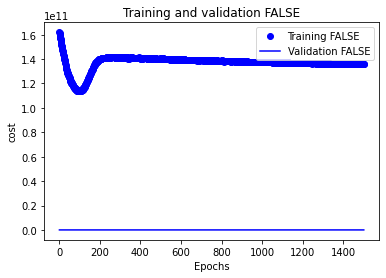

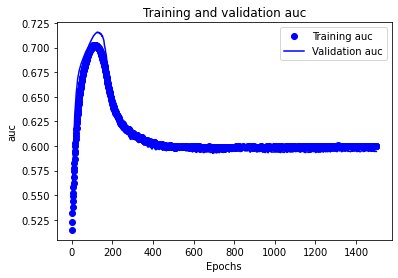

-----
step = 101
cost of false postive 23961037.599999998
cost of false negative 1644925231.2399998
number of false negative 2746.0
-----
-----
cost total =  1668886268.8399997
-----
percentage of cost that is false positive 1.4357501794687728
-----
percentage of cost that is false negative 98.56424982053123


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


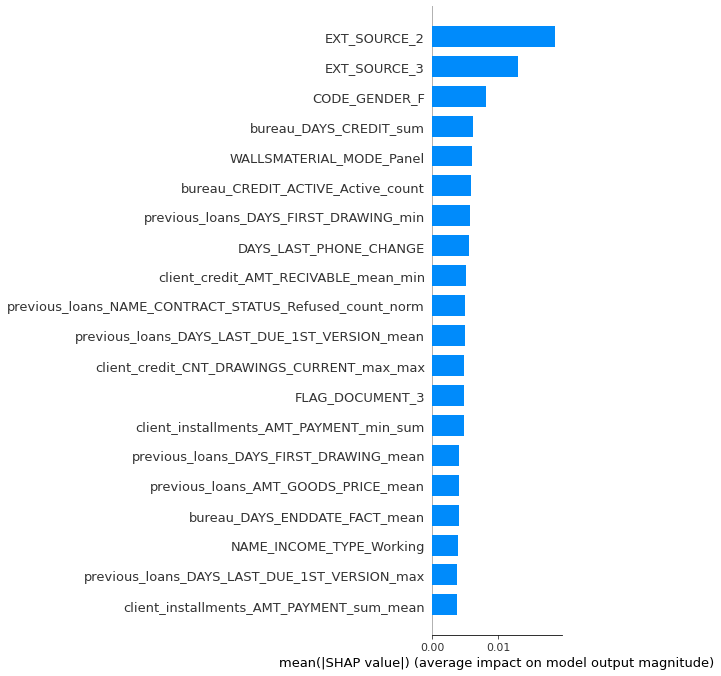

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 16)                5504      
_________________________________________________________________
dropout_48 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_49 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_74 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_75 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_50 (Dropout)         (None, 8)               

In [ ]:
shap.initjs()
main_thing_2(200)